# Final Project Submission

* Student name: `Reno Vieira Neto`
* Student pace: `self paced`
* Scheduled project review date/time: `Fri Oct 15, 2021 3pm – 3:45pm (PDT)`
* Instructor name: `James Irving`
* Blog post URL: https://renoneto.github.io/using_streamlit

#### This project originated the [following app](https://movie-recommender-reno.herokuapp.com/). I'd recommend playing with the app and then coming back here to understand how the model behind it works.

# Table of Contents <a class="anchor" id="toc"></a>
- **[Business Case and Goals](#bc)**
- **[The Dataset](#td)**
- **[Dataset Exploration and Cleaning](#dec)**
  - **[Number of Movies by Genre](#mg)**
  - **[Number of Ratings per Year](#ry)**
  - **[Number of Ratings per Release Year](#rry)**
  - **[Number of Users rating movies per Year](#urm)**
  - **[Number of Ratings by Rating Year and Movie Release Year](#rrymry)**
- **[Recommender System](#rs)**
  - **[Create Popularity Model](#pop)**
  - **[Collaborative-Based Filtering](#colab)**
    - **[Hyperparameter Tuning](#grid)**
    - **[Try different models](#dif)**
  - **[Model Evaluation](#eval)**
- **[Create function to take user input and give recommendations (+ hint of content-based attribute)](#func)**
- **[Conclusion](#conclusion)**
- **[Export files to create app](#lit)**
- **[Improvements](#improvements)**

# Business Case and Goal <a class="anchor" id="bc"></a>
In this project, I'm creating a movie recommender using the [MovieLens dataset](https://grouplens.org/datasets/movielens/) to build a model that provides top 5 movie recommendations to a user, based on their ratings of other movies. I'm going to be addressing the cold start problem as well by being able to deal with users with no movie ratings.

# The Dataset <a class="anchor" id="td"></a>
The MovieLens dataset is a "classic" recommendation system dataset used in numerous academic papers and machine learning proofs-of-concept.

[You can find more about it here](https://grouplens.org/datasets/movielens/)

# Dataset Exploration and Cleaning <a class="anchor" id="dec"></a>
## Import necessary packages 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import time
from surprise import Reader, Dataset, dump
from surprise.model_selection import GridSearchCV
from surprise.prediction_algorithms import KNNBasic, KNNBaseline, SVD, SVDpp
from surprise.accuracy import rmse
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from ast import literal_eval
import nltk
import warnings
from itertools import combinations

warnings.filterwarnings('ignore')
%config Completer.use_jedi = False
%matplotlib inline

In [2]:
# Import datasets
df_movies = pd.read_csv('../app/data/movies.csv')
df_ratings = pd.read_csv('../app/data/ratings.csv')

In [3]:
# Show first rows
display(df_movies.head())
display(df_ratings.head())

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


#### Notes
- Breakdown genres into different columns (one-hot encoding)
- `title` seems to have the release year of the movie. It might be interesting to have title and year in different columns.

In [4]:
# Check for nulls and data types
display(df_movies.info())
display(df_ratings.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


None

#### Notes
- No nulls
- Might need to convert timestamps to `datetime`
- There are 9742 movies in the dataset
- 100836 ratings

### `df_movies`
First, I'm going to start exploring the movies dataset to understand what I'm dealing with.

In [5]:
# Create column with array of genres and calculate the Number of Genres per movie
df_movies['genres_array'] = df_movies['genres'].str.split('|')

# Flattened genres
stacked_genres = df_movies['genres_array'].apply(pd.Series).stack(level=0).reset_index()
stacked_genres.columns = ['index', 'level_1', 'genre']

# Combine original dataframe with flattened genres using the index
df_movies_new = pd.merge(df_movies, stacked_genres, how='left', left_index=True, right_on=['index'])
df_movies_new = df_movies_new[['movieId', 'title', 'genre']]

In [6]:
# One-hot Encoding of Genre column
one_hot = pd.get_dummies(df_movies_new['genre'])

# Get list of genres (it's going to be useful soon)
list_of_genres = list(one_hot.columns)

# Combine the new dataframe with the one-hot encoded dataframe
df_movies_new = pd.merge(df_movies_new, one_hot, left_index=True, right_index=True)
df_movies_new = df_movies_new.drop('genre', axis=1)

# Use groupby to have one row per movie
df_movies_new = df_movies_new.groupby(['movieId', 'title']).sum()[list_of_genres].reset_index()

In [7]:
# Split year and title
df_movies_new['release_year'] = df_movies_new.apply(lambda x: x['title'].strip()[-5:][:-1], axis=1)
df_movies_new['release_year'] = df_movies_new.apply(lambda x: 
                                                    x['release_year'] 
                                                    if len(re.findall("[0-9]{4}", x['release_year'])) == 1 
                                                    else np.nan, axis=1)
df_movies_new['title'] = df_movies_new.apply(lambda x: 
                                             x['title'][:-6].strip()
                                             if x['release_year'] != np.nan
                                             else x['title'], axis=1)

### Number of Movies by genre <a class="anchor" id="mg"></a>
**[Go back to Table of Contents](#toc)**

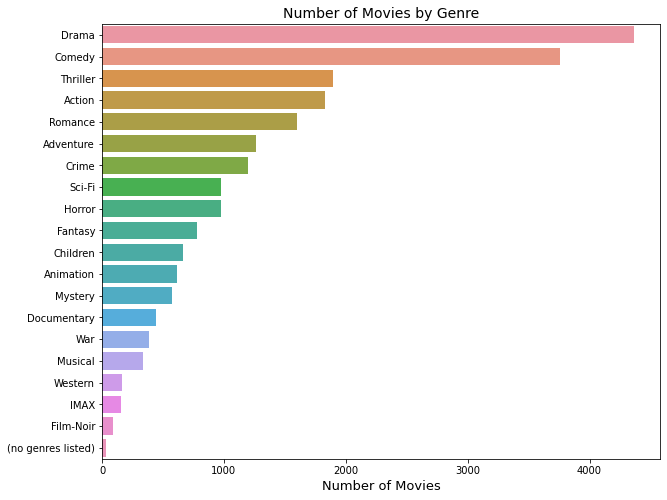

In [8]:
# Create empty dictionary to store the no of movies by genre
no_of_movies_by_genre = {}

for genre in list_of_genres:
    no_of_movies = df_movies_new[genre].sum()
    no_of_movies_by_genre[genre] = no_of_movies
    
# Transform that into a dataframe
to_plot = pd.DataFrame.from_dict(no_of_movies_by_genre, orient='index').reset_index()
to_plot.columns = ['genre', 'no_of_movies']
to_plot = to_plot.sort_values('no_of_movies', ascending=False).reset_index(drop=True)

# Plot
plt.figure(figsize=(10,8))
sns.barplot(x="no_of_movies", y="genre", data=to_plot)
plt.title('Number of Movies by Genre', size=14)
plt.xlabel('Number of Movies', size=13)
plt.ylabel(None)
plt.show()

#### Note
- We are dealing with an unbalanced dataset from the perspective of the genres. There are way more Drama and Comedy movies than other genres. The consequence of that to the model is that certain genres will have a smaller set of options to choose from.

### Number of Ratings by Genre

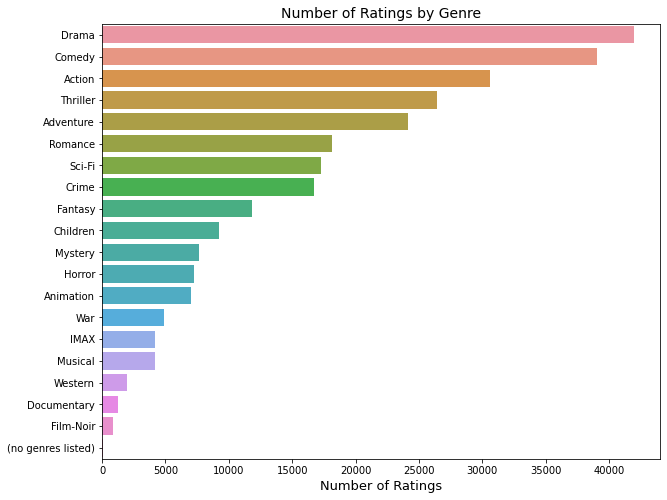

In [9]:
# Combine movies with stacked genres and add ratings
df_movies_stacked = pd.merge(df_movies, stacked_genres, how='left', left_index=True, right_on=['index'])
to_plot = pd.merge(df_movies_stacked, df_ratings, on='movieId')
to_plot = to_plot.groupby('genre').count()['movieId'].reset_index()
to_plot.columns = ['genre', 'no_of_ratings']
to_plot = to_plot.sort_values('no_of_ratings', ascending=False).reset_index(drop=True)

# Plot
plt.figure(figsize=(10,8))
sns.barplot(x="no_of_ratings", y="genre", data=to_plot)
plt.title('Number of Ratings by Genre', size=14)
plt.xlabel('Number of Ratings', size=13)
plt.ylabel(None)
plt.show()

**Note**
- Similar distribution as before, no surprises. However, ther's an easy way to compare both numbers:

### Average Number of Ratings by Movies and Genre

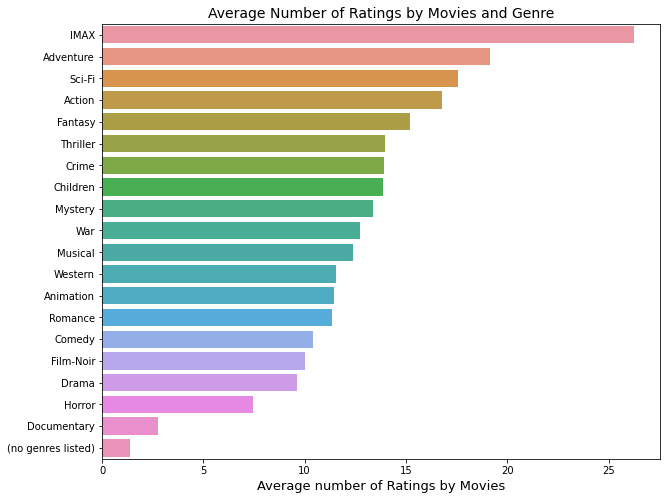

In [10]:
no_of_movies_by_genre = df_movies_stacked.groupby('genre').count()['movieId'].reset_index()
ratings_genres_movies = pd.merge(df_movies_stacked, df_ratings, on='movieId')
no_of_ratings_by_genre = ratings_genres_movies.groupby('genre').count()['rating']
combined_df = pd.merge(no_of_movies_by_genre, no_of_ratings_by_genre, on='genre')
combined_df.columns = ['genre', 'number_of_movies', 'number_of_ratings']
combined_df['number_of_ratings_by_movie'] = combined_df['number_of_ratings'] / combined_df['number_of_movies']
combined_df = combined_df.sort_values('number_of_ratings_by_movie', ascending=False).reset_index(drop=True)

# Plot
plt.figure(figsize=(10,8))
sns.barplot(x="number_of_ratings_by_movie", y="genre", data=combined_df)
plt.title('Average Number of Ratings by Movies and Genre', size=14)
plt.xlabel('Average number of Ratings by Movies', size=13)
plt.ylabel(None)
plt.show()

**Note**
- Oh that's interesting. The distribution here is different. IMAX, Adventure and Sci-Fi have more ratings than others on average.

Let see the movies, my guess is that those genres have higher chances of developing a fanbase around the movies (Star Wars, for example).

In [11]:
# Combine movies with stacked genres and add ratings
df_movies_stacked_ratings = pd.merge(df_movies_stacked, df_ratings, on='movieId')
genres_to_analyze = ['IMAX', 'Adventure', 'Sci-Fi']
filtered_df = df_movies_stacked_ratings[df_movies_stacked_ratings['genre'].isin(genres_to_analyze)]
filtered_df = filtered_df.groupby(['title', 'genre']).count()['movieId'].sort_values(ascending=False)\
                                                                        .reset_index()
filtered_df[['title', 'movieId']].drop_duplicates().head(15)


,title,movieId
0,"Matrix, The (1999)",278
1,Star Wars: Episode IV - A New Hope (1977),251
3,Jurassic Park (1993),238
5,Terminator 2: Judgment Day (1991),224
6,Toy Story (1995),215
7,Star Wars: Episode V - The Empire Strikes Back...,211
9,Independence Day (a.k.a. ID4) (1996),202
11,Apollo 13 (1995),201
13,Raiders of the Lost Ark (Indiana Jones and the...,200
14,"Lord of the Rings: The Fellowship of the Ring,...",198


**Note**
- As expected, some sequels with a big fanbase such as Start Wars, Terminator and Lord of the Rings. Also, some blockbusters suck as The Matrix and Jurassic Park.

### Ratings Distribution by Genre

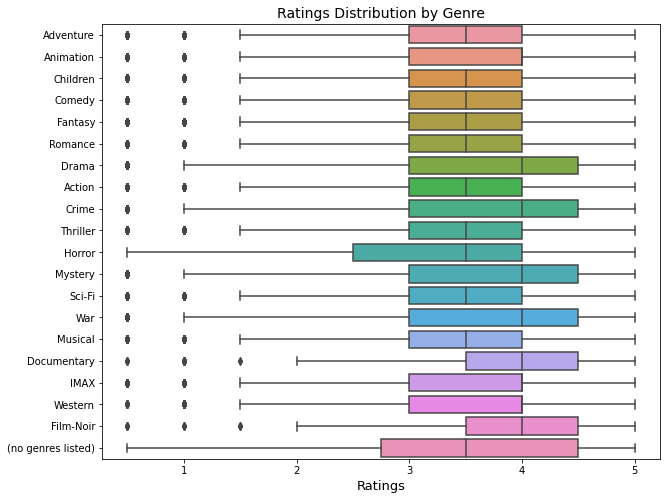

In [12]:
# Combine movies with stacked genres and add ratings
df_movies_stacked = pd.merge(df_movies, stacked_genres, how='left', left_index=True, right_on=['index'])
to_plot = pd.merge(df_movies_stacked, df_ratings, on='movieId')

# Plot
plt.figure(figsize=(10,8))
sns.boxplot(x='rating', y='genre', data=to_plot)

# Title and Label
plt.title('Ratings Distribution by Genre', size=14)
plt.xlabel('Ratings', size=13)
plt.ylabel(None)
plt.show();

**Note**


### `df_ratings`
### Number of Ratings per Year <a class="anchor" id="ry"></a>
I wonder how many ratings were created per year.

**[Go back to Table of Contents](#toc)**

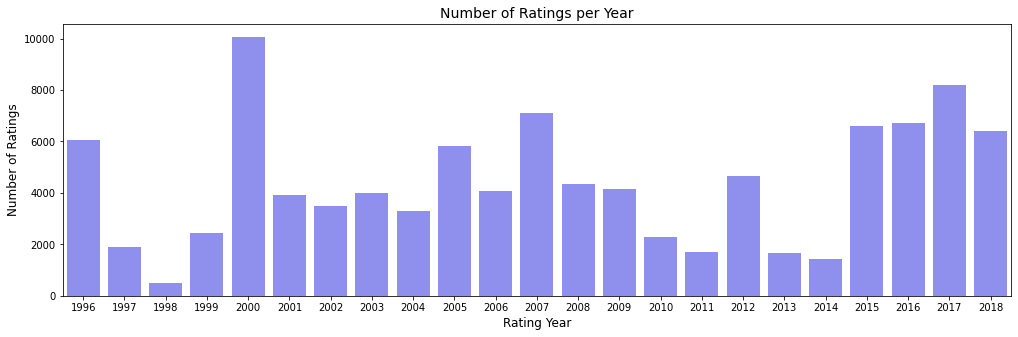

In [13]:
# Convert timestamp column to datetime
df_ratings['datetime'] = pd.to_datetime(df_ratings['timestamp'], unit='s')
df_ratings['year'] = df_ratings['datetime'].dt.year

# Create plot with Number of ratings per year
to_plot = df_ratings.groupby('year').count()['rating'].reset_index()
plt.figure(figsize=(17,5))
sns.barplot(x='year', y='rating', data=to_plot, color='blue', alpha=0.5)

# Set title and labels
plt.title('Number of Ratings per Year', size=14)
plt.xlabel('Rating Year', size=12)
plt.ylabel('Number of Ratings', size=12)
plt.show()

**Note**
- I don't see any trends. It's great to see that the last 4 years of the dataset had almost the same number of ratings.

### Number of Ratings per Release Year <a class="anchor" id="rry"></a>
**[Go back to Table of Contents](#toc)**

I wonder if movies from a certain year have more ratings than others.

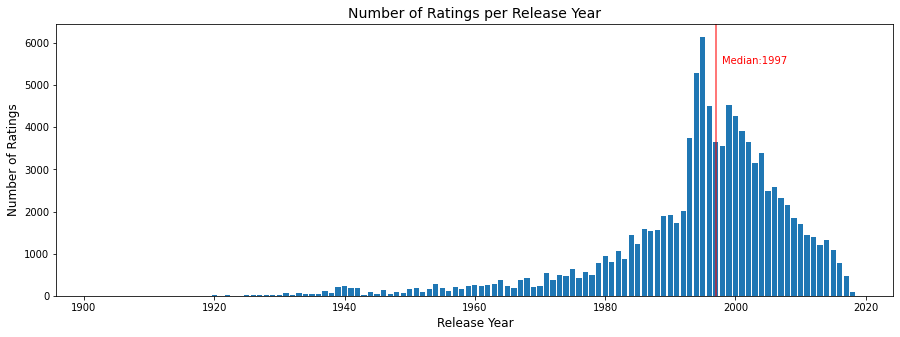

In [14]:
# Create plot with Number of Ratings per Release Year
to_plot = pd.merge(df_ratings, df_movies_new[['movieId', 'release_year']], on='movieId')
to_plot['release_year'] = pd.to_numeric(to_plot['release_year'])

# Calculate Median
median = to_plot['release_year'].median()

to_plot = to_plot.groupby('release_year').count()['movieId'].reset_index()

# Create plot
plt.figure(figsize=(15,5))
plt.bar(x=to_plot['release_year'],
        height=to_plot['movieId'])

# Add vertical line showing the median year
plt.axvline(x=median, color='red', alpha=0.7)
plt.text(median+1, 5500, f'Median:{int(median)}', color='red')

# Set title and labels
plt.title('Number of Ratings per Release Year', size=14)
plt.xlabel('Release Year', size=12)
plt.ylabel('Number of Ratings', size=12)
plt.show()

**Note**
- Most of the ratings come from movies released around 1997.

### Number of Ratings by Rating Year and Movie Release Year <a class="anchor" id="rrymry"></a>
**[Go back to Table of Contents](#toc)**

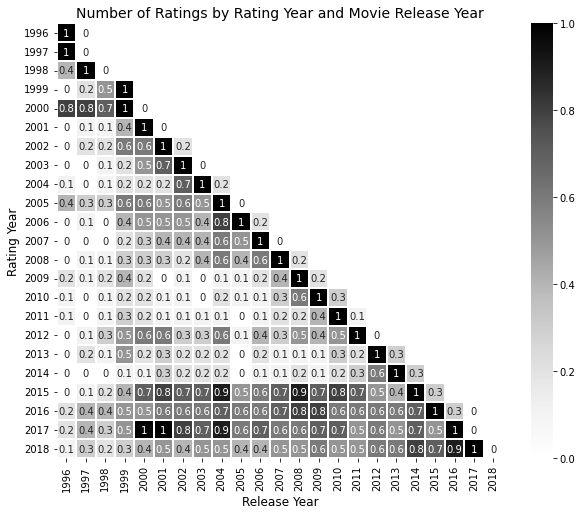

In [15]:
# Instead of adding colors by the absolute number of ratings, I'm going to rank them by scaling the number
# of votes per year. With that, it's going to be possible to see which Release years have the most number
# of ratings.
to_plot = pd.merge(df_ratings, df_movies_new[['movieId', 'release_year']], on='movieId')
min_year = to_plot['year'].min()
to_plot = to_plot[pd.to_numeric(to_plot['release_year']) >= min_year]
to_plot = to_plot.groupby(['year', 'release_year']).count()['userId'].reset_index()
to_plot['rank'] = round(to_plot.groupby('year')['userId'].apply(lambda x: (x-min(x))/(max(x)-min(x))), 1)
to_plot_pivot = to_plot.pivot(index='year', columns='release_year', values='rank')

# Create Plot
plt.figure(figsize=(10,8))
ax = sns.heatmap(to_plot_pivot,
                 annot=True,
                 linewidths=.01,
                 cmap="Greys")

# Set title and labels
plt.title('Number of Ratings by Rating Year and Movie Release Year', size=14)
ax.set_ylabel('Rating Year', size=12)
ax.set_xlabel('Release Year', size=12)
plt.show()

**Note**
- It's possible to see that users usually rate more movies released in the same year they're rating them. 
- Moreover, since 2015 we see a different behavior with users rating more movies from previous years.

### Number of Users rating movies per Year <a class="anchor" id="urm"></a>
**[Go back to Table of Contents](#toc)**

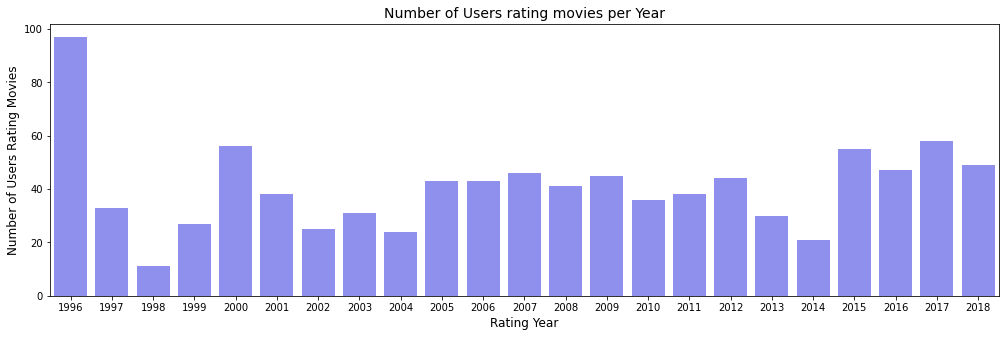

In [16]:
# Create Plot with Number of Unique Users giving ratings
to_plot = df_ratings.groupby('year').nunique()['userId'].reset_index()
plt.figure(figsize=(17,5))
sns.barplot(x='year', y='userId', data=to_plot, color='blue', alpha=0.5)

# Set title and labels
plt.title('Number of Users rating movies per Year', size=14)
plt.xlabel('Rating Year', size=12)
plt.ylabel('Number of Users Rating Movies', size=12)

plt.show()

**Note**
- Not many users rating movies. Around 40 per year.

### Average Ratings by Release Year <a class="anchor" id="arry"></a>
**[Go back to Table of Contents](#toc)**

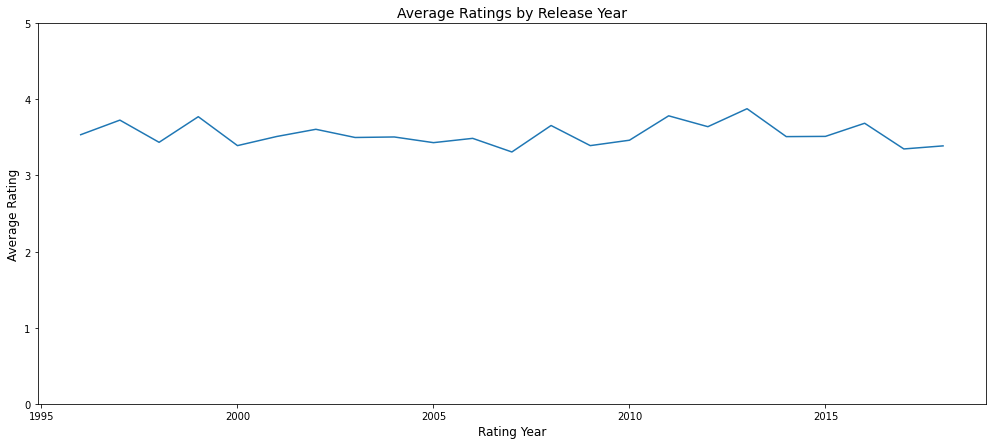

In [17]:
# Sort the dataframe using the rating year
to_plot = df_ratings.copy()
to_plot['year'] = pd.to_numeric(to_plot['year'])
to_plot = to_plot.sort_values('year').reset_index(drop=True)

# Create plot
plt.figure(figsize=(17,7))
ax = sns.lineplot(x='year', y='rating', estimator=np.mean, data=to_plot, ci=None)

# Set title and labels
plt.title('Average Ratings by Release Year', size=14)
plt.xlabel('Rating Year', size=12)
plt.ylabel('Average Rating', size=12)
plt.yticks(range(0,6))
plt.show();

**Note**
- The annual average rating doesn't change much over time.

# Recommender System <a class="anchor" id="rs"></a>
## Create Popularity Model <a class="anchor" id="pop"></a>
The first model is going to be very simple. It's a popularity model. Basically I'm going to rank movies by popularity. However, I need to find a way to scale the ratings because a movie with 100 ratings with an average of 4.5 and another with 2 with an average of 4.75 are completely different. I'd argue that the first movie actually has a higher rating score than the second one since more users have rated it with a high score. 

To address that problem I'm using the IMDB's Weighted Rating Method I found [online](https://math.stackexchange.com/questions/169032/understanding-the-imdb-weighted-rating-function-for-usage-on-my-own-website) that does a good job at weighting the ratings.

#### Calculation
![](https://image.ibb.co/jYWZp9/wr.png)
where,
* v is the number of votes for the movie;
* m is the minimum votes required to be listed in the chart;
* R is the average rating of the movie; And
* C is the mean vote across the whole report

#### C: Calculate mean vote across the whole dataset

In [18]:
# Calculate Mean and Count the Number of Ratings to a given movie
mean_ratings_df = df_ratings.groupby('movieId').agg(avg_rating=('rating', 'mean'), 
                                                count_rating=('rating', 'count')).reset_index()
# Calculate the Overall Average Rating
mean_ratings_df['overall_avg_rating'] = mean_ratings_df['avg_rating'].mean()
mean_ratings_df.head()

,movieId,avg_rating,count_rating,overall_avg_rating
0,1,3.920930,215,3.262448
1,2,3.431818,110,3.262448
2,3,3.259615,52,3.262448
3,4,2.357143,7,3.262448
4,5,3.071429,49,3.262448


#### m: Define the minimum number of ratings required to be listed
To define the minimum number of votes I'm going to look at the distribution of Number of Ratings by Movies.

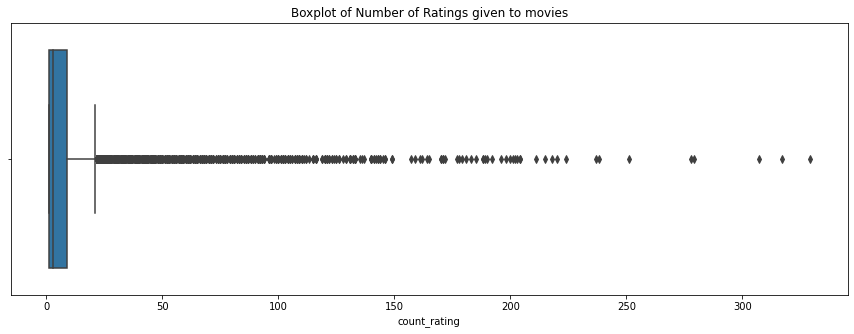

In [19]:
# Plot
plt.figure(figsize=(15,5))
sns.boxplot(x=mean_ratings_df['count_rating'])
plt.title('Boxplot of Number of Ratings given to movies')
plt.show()

Not super helpful. I'm going to print different quantiles

In [20]:
# Calculate different quatiles
n_of_users = df_ratings['userId'].nunique()
n_of_movies = len(mean_ratings_df)
quantiles_list = []

for n in range(10, 100, 5):
    q = mean_ratings_df['count_rating'].quantile(n/100)
    n_of_selected_movies = len(mean_ratings_df[mean_ratings_df['count_rating'] >= q])
    quantiles_list.append([n, q, n_of_selected_movies])

pd.DataFrame(quantiles_list, columns=['quantile', 'quantile_value', 'number_of_movies'])

,quantile,quantile_value,number_of_movies
0,10,1.0,9724
1,15,1.0,9724
2,20,1.0,9724
3,25,1.0,9724
4,30,1.0,9724
5,35,1.0,9724
6,40,2.0,6278
7,45,2.0,6278
8,50,3.0,4980
9,55,3.0,4980


Before deciding the Minimum Number of Ratings, I'm going to look at the number of movies users have rated. 

In [21]:
df_ratings.groupby('userId').count()['movieId'].describe()

count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
Name: movieId, dtype: float64

The Median number of movies a user has rated is 70 movies and the 75th quantile is 168 movies. 

Therefore, I'm comfortable moving forward with having the Minimum Number of Ratings (or `m`) of 47 ratings since that represents 491 Movies which is more than most users have rated.

> **Disclamer**: I have tried a minimum of 27/17 ratings as well, however, the model resulted in weird recommendations. So I'm picking 47 after iteratively trying 17 and 27.

#### m = 47

#### Create function to apply to the dataset

In [22]:
def weighted_rating(df):
    """
    Calculates the IMDB's Weighted Rating using the following formula:
        (v / (v+m) * R) + (m / (m+v) * C)
    
    where:
    - v is the number of votes for the movie;
    - m is the minimum votes required to be listed in the chart;
    - R is the average rating of the movie; And
    - C is the mean vote across the whole report
    """
    v = df['count_rating']
    m = df['minimum_no_of_ratings']
    R = df['avg_rating']
    C = df['overall_avg_rating']
    
    return (v / (v+m) * R) + (m / (m+v) * C)

# Create Copy
popularity_df = mean_ratings_df.copy()

# Calculate the 95th quantile and the weighted rating
popularity_df['minimum_no_of_ratings'] = popularity_df['count_rating'].quantile(0.95)
popularity_df['weighted_rating'] = popularity_df.apply(weighted_rating, axis=1)

I'm going to look at the top 10 movies with the highest ratings.

In [23]:
# Grab the top 10 ids
top_ten_ids = popularity_df.sort_values('weighted_rating', ascending=False)['movieId'][:10].values

# Print them
for idx, movie_id in enumerate(top_ten_ids):
    print((idx + 1), df_movies[df_movies['movieId'] == movie_id]['title'].item())

1 Shawshank Redemption, The (1994)
2 Fight Club (1999)
3 Godfather, The (1972)
4 Star Wars: Episode IV - A New Hope (1977)
5 Pulp Fiction (1994)
6 Matrix, The (1999)
7 Schindler's List (1993)
8 Usual Suspects, The (1995)
9 Forrest Gump (1994)
10 Star Wars: Episode V - The Empire Strikes Back (1980)


Not too bad, I agree with these being the top 10. _However, that's very personal._

**[Go back to Table of Contents](#toc)**

## Content-Based Filtering <a class="anchor" id="colab"></a>

In [24]:
# Import datasets
df_movie_info = pd.read_csv('../app/data/movie_info.csv')

#### Generate recommendations using only `description`

In [25]:
# Combine movie info with movie title
df_movie_info_title = pd.merge(df_movies_new[['movieId', 'title']], df_movie_info, on='movieId')
df_movie_info_title['movie_keywords'] = df_movie_info_title['movie_keywords'].apply(literal_eval)

In [26]:
# Create TF-IDF for words in the description
tf = TfidfVectorizer(analyzer='word', 
                     ngram_range=(1, 2), 
                     min_df=0, 
                     stop_words='english')

tfidf_matrix = tf.fit_transform(df_movie_info_title['movie_description'])

# Since we have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the 
# Cosine Similarity Score. Therefore, we will use sklearn's linear_kernel instead of cosine_similarities 
# since it is much faster.
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [27]:
def get_recommendations(title, sim_scores, df_movie_info_title):
    # Grab the index from dataframe
    idx = df_movie_info_title.loc[df_movie_info_title['title'] == title].index[0]
    
    # Extract scores and sort them
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Keep only top 10 recommendations and return that
    sim_scores = sim_scores[1:10]
    # Ignore movies with no score
    movie_indices = [i[0] for i in sim_scores if i[1] != 0]

    return df_movie_info_title.iloc[movie_indices][['title']]

In [28]:
get_recommendations('Toy Story', cosine_sim, df_movie_info_title)

,title
1472,Toy Story 2
904,Child's Play
906,Child's Play 3
4261,Toy Story 3
905,Child's Play 2
3669,It's a Boy Girl Thing
1317,Funny Farm
3382,"40-Year-Old Virgin, The"
4706,"Guilt Trip, The"


Some of the movies make sense but I'm surprised to see `40-Year-Old Virgin, The`

In [29]:
get_recommendations('Dark Knight, The', cosine_sim, df_movie_info_title)

,title
87,Batman Forever
647,Batman Returns
343,Batman
1513,Batman: Mask of the Phantasm
5451,The Lego Batman Movie
5216,Batman v Superman: Dawn of Justice
3354,Batman Begins
5392,Batman: The Killing Joke
4540,"Dark Knight Rises, The"


It's returning all batman movies. I'd prefer to have `Dark Knight Rises, The` on the top.

> Using only description is not a good option. For Batman, for example, it will bring all Batman movies, regardless of the release year, cast or anything else.

#### Generate recommendations using only `cast`
A few points regarding the transformations below:
- I noticed that some cast members appear twice in the cast because they have multiple roles (Director and Writer). Although it might be interesting to keep that information, it ends up removing some other cast members that might be important for the recommender. Therefore, I'm keeping only one instance of each `cast_name`.
- Certain cast members are not as relevant as others. To filter out outliers, I have decided to keep only members who have done at least one movie. If somebody is present in only one movie than it's not very helpful for the recommender since we cannot find the same person elsewhere.
- Finally, I'm keeping the top 15 cast members. Gladly the cast dataset comes in order of importance, which is set by iMDB. Not sure how they do that but I have checked some movies and the order prioritizes important members, therefore, I'm going to use that in my advantage.

In [30]:
# Import cast
df_movie_cast = pd.read_csv('../app/data/cast.csv')

# I have found duplicates and I'm going to drop them and 
df_movie_cast = df_movie_cast.drop_duplicates(['movieId', 'cast_name'])
print('Number of Rows (All Cast Members):', len(df_movie_cast))

# Keep only cast members in more than one movie
cast_count = df_movie_cast.groupby('cast_name').count()['movieId'].reset_index()
cast_count.columns = ['cast_name', 'count']
cast_name_filtered = list(cast_count[cast_count['count'] > 1]['cast_name'])
cast_name_filtered = set(cast_name_filtered)
df_movie_cast = df_movie_cast[df_movie_cast['cast_name'].isin(cast_name_filtered)]
print('Filtered number of Rows (only members who have done more than one movie):', len(df_movie_cast))

# Create a new column with new order
df_movie_cast['new_order'] = df_movie_cast.groupby('movieId').rank()['cast_order']

# After reviewing different casts I'm going to keep the first 15 cast members
# I found that to be a good number
df_movie_cast = df_movie_cast[df_movie_cast['new_order'] < 15]
print('Further filtered number of Rows (top 15 cast members of movies):', len(df_movie_cast))

Number of Rows (All Cast Members): 356272
Filtered number of Rows (only members who have done more than one movie): 228702
Further filtered number of Rows (top 15 cast members of movies): 74430


#### Giving different weight based on the member's cast order
Since the order of the cast is already sorted by importance. I'm going to give more weight to members with more importance. To achieve that, I'm multiplying the same `cast_name`, so the same name is present in the cast multiple times, giving it more weight. With that, the model will prioritize movies with similar cast members.

Since I'm keeping only the first 15 members, I'm also multiplying the name by 15 times minus the order ranking. Therefore, the following will happen:
- First Cast Member: Name A * (15 - (1 - 1)) = Name A * 15
- Second Cast Member: Name B * (15 - (2 - 1)) = Name B * 14
- Third Cast Member: Name C * (15 - (3 - 1)) = Name C * 13

**_Note: 15 is an arbitrary number that will be put to test later on._**

In [31]:
# Create Multiplier to give top cast members more weight
df_movie_cast['multiplier'] = 15 - (df_movie_cast['new_order'] - 1)
df_movie_cast['clean_cast_name'] = df_movie_cast['cast_name'].str.lower().str.replace(' ', '')
df_movie_cast['weighted_cast'] = df_movie_cast.apply(lambda x: (x['clean_cast_name'] + ' ') 
                                                     * int(x['multiplier'])
                                                     , axis=1)

# Create a column with weighted cast
df_movie_cast_modified = df_movie_cast.groupby('movieId')['weighted_cast']\
                                      .apply(lambda x: ' '.join(x))\
                                      .reset_index()

df_movie_cast_modified.iloc[0]['weighted_cast']

'johnlasseter johnlasseter johnlasseter johnlasseter johnlasseter johnlasseter johnlasseter johnlasseter johnlasseter johnlasseter johnlasseter johnlasseter johnlasseter johnlasseter johnlasseter  petedocter petedocter petedocter petedocter petedocter petedocter petedocter petedocter petedocter petedocter petedocter petedocter petedocter petedocter  andrewstanton andrewstanton andrewstanton andrewstanton andrewstanton andrewstanton andrewstanton andrewstanton andrewstanton andrewstanton andrewstanton andrewstanton andrewstanton  joeranft joeranft joeranft joeranft joeranft joeranft joeranft joeranft joeranft joeranft joeranft joeranft  josswhedon josswhedon josswhedon josswhedon josswhedon josswhedon josswhedon josswhedon josswhedon josswhedon josswhedon  joelcohen joelcohen joelcohen joelcohen joelcohen joelcohen joelcohen joelcohen joelcohen joelcohen  alecsokolow alecsokolow alecsokolow alecsokolow alecsokolow alecsokolow alecsokolow alecsokolow alecsokolow  tomhanks tomhanks tomhan

Notice above how I'm repeating the cast names to give more weight to certain members.

In [32]:
# Refit TD-IDF model
df_movie_cast_test = pd.merge(df_movie_info_title, df_movie_cast_modified, on='movieId')
tfidf_matrix = tf.fit_transform(df_movie_cast_test['weighted_cast'])
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [33]:
get_recommendations('Toy Story', cosine_sim, df_movie_cast_test)

,title
1092,"Bug's Life, A"
4232,Toy Story 3
1462,Toy Story 2
3875,WALL·E
3516,Cars
3013,Garfield: The Movie
730,Money Talks
2619,Finding Nemo
4551,John Carter


In [34]:
get_recommendations('Dark Knight, The', cosine_sim, df_movie_cast_test)

,title
4509,"Dark Knight Rises, The"
3331,Batman Begins
3593,"Prestige, The"
4867,Interstellar
1946,Memento
3124,Blade: Trinity
3823,Jumper
795,Dark City
4544,Ghost Rider: Spirit of Vengeance


#### Conclusions:
> The recommendations make a lot more sense to me now. I'd expect for _'Toy Story'_ to return the sequels first but it's returning _'A Bug's Life'_, which is fine given that both movies have the same Director and some other cast members. 
>
>_'The Dark Night'_ had really good recommendations. However, it seems to be overfitting on the Director (Christopher Nolan) as well.
>
> The problem is probably related to the weight I'm giving to the cast order. The model is giving too much weight to Directors or whoever comes in the top. I need to address that in future iterations.

#### Generate recommendations using only cast pairs
The idea is that certain movies might be more relevant if they share the same pairs of cast members.

In [35]:
def cast_combinations(df_movie_cast,
                      no_of_cast_members=10,
                      no_of_elements=2):
    cast_rows = df_movie_cast.iloc[:no_of_cast_members]
    lst_of_combinations = [i for i in combinations(list(cast_rows['cast_name']), no_of_elements)]
    lst_of_combinations = [''.join(sorted(i)) for i in lst_of_combinations]
    lst_of_combinations = [i.lower().replace(' ', '') for i in lst_of_combinations]
    
    return (" ".join(lst_of_combinations) + " ") * no_of_cast_members

In [36]:
# Create all different combinations of pairs
df_movie_cast_combinations = df_movie_cast.groupby('movieId').apply(lambda x: cast_combinations(x, 5, 2))
df_movie_cast_combinations = df_movie_cast_combinations.reset_index()
df_movie_cast_combinations.columns = ['movieId', 'cast_combinations']
df_movie_cast_combinations.head()

,movieId,cast_combinations
0,1,johnlasseterpetedocter andrewstantonjohnlasset...
1,2,frankwelkerjoejohnston frankwelkerjonathanhens...
2,3,jacklemmonwaltermatthau burgessmeredithjacklem...
3,4,forestwhitakerronaldbass forestwhitakerwhitney...
4,5,dianekeatonstevemartin kieranculkinstevemartin...


In [37]:
# Refit TD-IDF model
df_movie_cast_pairs_test = pd.merge(df_movie_info_title, df_movie_cast_combinations, on='movieId')
tfidf_matrix = tf.fit_transform(df_movie_cast_pairs_test['cast_combinations'])
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [38]:
get_recommendations('Toy Story', cosine_sim, df_movie_cast_pairs_test)

,title
1092,"Bug's Life, A"
3875,WALL·E
3516,Cars


In [39]:
get_recommendations('Dark Knight, The', cosine_sim, df_movie_cast_pairs_test)

,title
4544,Ghost Rider: Spirit of Vengeance
795,Dark City
3593,"Prestige, The"
4509,"Dark Knight Rises, The"
3124,Blade: Trinity
1010,Blade
556,"Sting, The"
316,Sleepless in Seattle
3576,Flyboys


#### Conclusions:
>The recommendations for 'Toy Story' have improved but I'm not so sure about 'The Dark Knight'. The first two make sense, but I'm surprised to see 'Ghost Rider'.

#### Generate recommendations using only `movie_keywords`

In [40]:
#nltk.download('wordnet')
lemma = nltk.wordnet.WordNetLemmatizer()

In [41]:
# Lemmatize keywords so movies have similar keywords and become easier to group/combine
df_movie_info_title['movie_keywords'] = df_movie_info_title.apply(lambda x: \
                                                                  [lemma.lemmatize(i) \
                                                                   for i in x['movie_keywords']]\
                                                                  , axis=1)

df_movie_info_title['movie_keywords'] = df_movie_info_title['movie_keywords'].apply(lambda x: ' '.join(x))

In [42]:
# Refit TD-IDF model
tfidf_matrix = tf.fit_transform(df_movie_info_title['movie_keywords'])
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [43]:
get_recommendations('Toy Story', cosine_sim, df_movie_info_title)

,title
1472,Toy Story 2
46,"Indian in the Cupboard, The"
862,Small Soldiers
5274,The Little Prince
4116,9
1196,Christine
4319,Rubber
3901,WALL·E
3129,"Incredibles, The"


In [44]:
get_recommendations('Dark Knight, The', cosine_sim, df_movie_info_title)

,title
343,Batman
42,"Usual Suspects, The"
2245,Ocean's Eleven
647,Batman Returns
1248,Superman II
3727,Ocean's Thirteen
3354,Batman Begins
2395,Road to Perdition
1803,Supergirl


#### Conclusions:
>I'm not happy with the recommendations. Not sure if the keywords are providing good recommendations.

#### Combine all fields

In [45]:
# Merge all necessary dataframes
df_movie_info_title = pd.merge(df_movie_cast_modified, df_movie_info_title, on='movieId')
df_movie_info_title = pd.merge(df_movie_info_title, 
                               df_movie_cast_combinations[['movieId', 'cast_combinations']], 
                               on='movieId')

In [46]:
# Create a list with the movies that will be tested
test_movies = ['Toy Story', 
               'Dark Knight, The', 
               'Godfather, The',
               'Shawshank Redemption, The',
               'Fight Club',
               'Pulp Fiction',
               'Matrix, The',
               'Forrest Gump',
               'Usual Suspects, The']

# Content field names
field_names = ['title', 'movie_description', 
               'movie_plot', 'movie_keywords', 
               'cast_combinations', 'weighted_cast']

In [47]:
# Create all different combinations of the field names, from having only one to all
field_combs = []

for i in range(1,7):
    for comb in list(combinations(field_names, i)):
        field_combs.append(comb)
        
print('Number of Field Combinations:', len(field_combs))

Number of Field Combinations: 63


Now it's time to iterate through the different combinations of content fields, fit the model and get recommendations.

In [48]:
results = []
length = len(field_combs)

# Loop through the different combinations of fields
for idx, field_comb in enumerate(field_combs):
    
    # Create 'features' with the chosen combination
    temp_df = df_movie_info_title.copy()
    temp_df['features'] = temp_df[list(field_comb)].agg(' '.join, axis=1)
    
    # Refit TF-IDF
    tfidf_matrix = tf.fit_transform(temp_df['features'])
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
    
    # Generate recommendations for the test movies and reformat the dataframe to store results
    for test_movie in test_movies:
        reco = get_recommendations(test_movie, cosine_sim, temp_df)
        reco = reco.reset_index(drop=True).transpose().reset_index(drop=True)
        reco['target_movie'] = test_movie        
        reco['combinations'] = ", ".join(list(field_comb))
        results.append(reco)
    
    # Print completion
    if idx % 10 == 0:
        print('Completion:', round(((idx+1)/length),2))

Completion: 0.02
Completion: 0.17
Completion: 0.33
Completion: 0.49
Completion: 0.65
Completion: 0.81
Completion: 0.97


In [49]:
# Put results together
comb_results_df = pd.concat(results)
comb_results_df.columns = ['rec_' + str(i) for i in range(9)] + list(comb_results_df.columns[9:])

Analyze `Toy Story`

I'm going to start by making sure that the other two Toy Story movies are in the top 3 recommendations.

In [50]:
comb_results_df[(comb_results_df['target_movie'] == 'Toy Story') & 
               
                # Toy Story 2 has to be in the top 3 recommendations
               ((comb_results_df['rec_0'].str.contains('Toy Story 2')) |
               (comb_results_df['rec_1'].str.contains('Toy Story 2')) |
               (comb_results_df['rec_2'].str.contains('Toy Story 2'))) &
                
                # Toy Story 3 has to be in the top 3 recommendations
               ((comb_results_df['rec_0'].str.contains('Toy Story 3')) |
               (comb_results_df['rec_1'].str.contains('Toy Story 3')) |
               (comb_results_df['rec_2'].str.contains('Toy Story 3')))
               ]

,rec_0,rec_1,rec_2,rec_3,rec_4,rec_5,rec_6,rec_7,rec_8,target_movie,combinations
0,Toy Story 2,Toy Story 3,"Toy, The",L.A. Story,Toy Soldiers,Love Story,Ghost Story,"Christmas Story, A",True Story,Toy Story,title
0,"Bug's Life, A",Toy Story 3,Toy Story 2,WALL·E,Cars,Garfield: The Movie,Money Talks,Finding Nemo,John Carter,Toy Story,weighted_cast
0,Toy Story 2,Toy Story 3,Child's Play,Child's Play 3,Child's Play 2,It's a Boy Girl Thing,Funny Farm,"40-Year-Old Virgin, The",Home Alone 3,Toy Story,"title, movie_description"
0,Toy Story 2,"Toy, The",Toy Story 3,Toy Soldiers,Home Alone 3,Dolls,Small Soldiers,Bride of Chucky (Child's Play 4),"Great Mouse Detective, The",Toy Story,"title, movie_plot"
0,Toy Story 2,Toy Story 3,Small Soldiers,The Little Prince,9,Toy Soldiers,Masters of the Universe,The Lego Movie,WALL·E,Toy Story,"title, movie_keywords"
0,"Bug's Life, A",Toy Story 3,Toy Story 2,WALL·E,Cars,Garfield: The Movie,Money Talks,Finding Nemo,John Carter,Toy Story,"title, weighted_cast"
0,Toy Story 2,Toy Story 3,Child's Play 2,Child's Play,Child's Play 3,Small Soldiers,It's a Boy Girl Thing,"Guilt Trip, The",Home Alone 3,Toy Story,"movie_description, movie_plot"
0,"Bug's Life, A",Toy Story 3,Toy Story 2,WALL·E,Cars,Garfield: The Movie,Money Talks,Finding Nemo,John Carter,Toy Story,"movie_description, weighted_cast"
0,"Bug's Life, A",Toy Story 3,Toy Story 2,WALL·E,Cars,Garfield: The Movie,Money Talks,Finding Nemo,John Carter,Toy Story,"movie_plot, weighted_cast"
0,"Bug's Life, A",Toy Story 3,Toy Story 2,WALL·E,Cars,Garfield: The Movie,Money Talks,Finding Nemo,John Carter,Toy Story,"movie_keywords, weighted_cast"


The recommendations overall are very good. However, I'm seeing the movie `Child's Play` in some recommendations which is not a good thing because it's an horror movie. It would probably be a good idea to have some filter applied to the movie's genre.

In this particular example it seems the recommendation comes when adding `movie_description` or `plot` without the cast.

#### Next, I'll analyze `The Dark Knight`
I'm going to keep the same approach and make sure that we have `The Dark Knight Rises` and `Batman Begins` in the top 3 recommendations.

In [51]:
comb_results_df[(comb_results_df['target_movie'] == 'Dark Knight, The') & 
                
                # Dark Knight has to be in the top 3 recommendations
               ((comb_results_df['rec_0'].str.contains('Dark Knight')) |
               (comb_results_df['rec_1'].str.contains('Dark Knight')) |
               (comb_results_df['rec_2'].str.contains('Dark Knight'))) &
                
                # Batman Begins has to be in the top 3 recommendations
               ((comb_results_df['rec_0'].str.contains('Batman Begins')) |
               (comb_results_df['rec_1'].str.contains('Batman Begins')) |
               (comb_results_df['rec_2'].str.contains('Batman Begins')))]

,rec_0,rec_1,rec_2,rec_3,rec_4,rec_5,rec_6,rec_7,rec_8,target_movie,combinations
0,Secret Admirer,Batman Begins,"Dark Knight Rises, The",Batman Returns,Batman & Robin,Batman,Batman: The Killing Joke,Alexander,Kill Bill: Vol. 1,"Dark Knight, The",movie_plot
0,"Dark Knight Rises, The",Batman Begins,"Prestige, The",Interstellar,Memento,Blade: Trinity,Jumper,Dark City,Ghost Rider: Spirit of Vengeance,"Dark Knight, The",weighted_cast
0,Batman,"Dark Knight Rises, The",Batman Begins,Batman Returns,Secret Admirer,Batman & Robin,Batman: The Killing Joke,"Knight's Tale, A",Batman: Mask of the Phantasm,"Dark Knight, The","title, movie_plot"
0,"Dark Knight Rises, The",Batman Begins,"Prestige, The",Interstellar,Memento,Blade: Trinity,Jumper,Dark City,Ghost Rider: Spirit of Vengeance,"Dark Knight, The","title, weighted_cast"
0,"Dark Knight Rises, The",Batman Begins,"Prestige, The",Interstellar,Memento,Blade: Trinity,Jumper,Dark City,Ghost Rider: Spirit of Vengeance,"Dark Knight, The","movie_description, weighted_cast"
0,Batman,"Dark Knight Rises, The",Batman Begins,Batman: The Killing Joke,Batman Returns,Batman: Mask of the Phantasm,The Lego Batman Movie,Secret Admirer,Superman,"Dark Knight, The","movie_plot, movie_keywords"
0,"Dark Knight Rises, The",Batman Begins,"Prestige, The",Interstellar,Memento,Blade: Trinity,Jumper,Dark City,"Crow: City of Angels, The","Dark Knight, The","movie_plot, weighted_cast"
0,"Dark Knight Rises, The",Batman Begins,"Prestige, The",Interstellar,Memento,Blade: Trinity,Jumper,Dark City,Ghost Rider: Spirit of Vengeance,"Dark Knight, The","movie_keywords, weighted_cast"
0,"Dark Knight Rises, The",Batman Begins,"Prestige, The",Blade: Trinity,Dark City,Jumper,Ghost Rider: Spirit of Vengeance,Blade,Interstellar,"Dark Knight, The","cast_combinations, weighted_cast"
0,"Dark Knight Rises, The",Batman Begins,"Prestige, The",Interstellar,Memento,Blade: Trinity,Jumper,Dark City,Ghost Rider: Spirit of Vengeance,"Dark Knight, The","title, movie_description, weighted_cast"


I noticed that recommendations started to make more sense after adding the cast, but it seems to overfit by keeping all Christopher Nolan's movies.

#### Next, I'll analyze `Pulp Fiction`
Same approach will be taken (after further review I noticed that having Reservoir Dogs and The Hateful Eight would bring good results.

In [52]:
comb_results_df[(comb_results_df['target_movie'] == 'Pulp Fiction') &
                
                # Reservoir Dogs has to be in the top 3 recommendations
               ((comb_results_df['rec_0'].str.contains('Reservoir Dogs')) |
               (comb_results_df['rec_1'].str.contains('Reservoir Dogs')) |
               (comb_results_df['rec_2'].str.contains('Reservoir Dogs'))) &
                
                # The Hateful Eight has to be in the top 3 recommendations
               ((comb_results_df['rec_0'].str.contains('The Hateful Eight')) |
               (comb_results_df['rec_1'].str.contains('The Hateful Eight')) |
               (comb_results_df['rec_2'].str.contains('The Hateful Eight')))]

,rec_0,rec_1,rec_2,rec_3,rec_4,rec_5,rec_6,rec_7,rec_8,target_movie,combinations
0,Reservoir Dogs,True Romance,The Hateful Eight,Django Unchained,Jackie Brown,"Rules of Attraction, The",Silent Hill,Basic,Inglourious Basterds,Pulp Fiction,weighted_cast
0,Reservoir Dogs,True Romance,The Hateful Eight,Django Unchained,Jackie Brown,"Rules of Attraction, The",Silent Hill,Basic,Inglourious Basterds,Pulp Fiction,"title, weighted_cast"
0,Reservoir Dogs,The Hateful Eight,True Romance,Django Unchained,Jackie Brown,"Rules of Attraction, The",Silent Hill,Inglourious Basterds,Basic,Pulp Fiction,"movie_description, weighted_cast"
0,Reservoir Dogs,The Hateful Eight,True Romance,Django Unchained,Jackie Brown,"Rules of Attraction, The",Silent Hill,Basic,Inglourious Basterds,Pulp Fiction,"movie_plot, weighted_cast"
0,Reservoir Dogs,True Romance,The Hateful Eight,Django Unchained,Jackie Brown,"Rules of Attraction, The",Silent Hill,Basic,Inglourious Basterds,Pulp Fiction,"movie_keywords, weighted_cast"
0,Reservoir Dogs,The Hateful Eight,True Romance,Jackie Brown,Django Unchained,Basic,"Rules of Attraction, The",Silent Hill,Unbreakable,Pulp Fiction,"cast_combinations, weighted_cast"
0,Reservoir Dogs,The Hateful Eight,True Romance,Django Unchained,Jackie Brown,"Rules of Attraction, The",Silent Hill,Inglourious Basterds,Basic,Pulp Fiction,"title, movie_description, weighted_cast"
0,Reservoir Dogs,The Hateful Eight,True Romance,Django Unchained,Jackie Brown,"Rules of Attraction, The",Silent Hill,Basic,Inglourious Basterds,Pulp Fiction,"title, movie_plot, weighted_cast"
0,Reservoir Dogs,True Romance,The Hateful Eight,Django Unchained,Jackie Brown,"Rules of Attraction, The",Silent Hill,Basic,Inglourious Basterds,Pulp Fiction,"title, movie_keywords, weighted_cast"
0,Reservoir Dogs,The Hateful Eight,True Romance,Jackie Brown,Django Unchained,Basic,"Rules of Attraction, The",Silent Hill,Unbreakable,Pulp Fiction,"title, cast_combinations, weighted_cast"


I'm happy with the recommendation that includes the `weighted cast` and `cast_combinations`.

In [53]:
comb_results_df[(comb_results_df['combinations'] == 'cast_combinations, weighted_cast')]

,rec_0,rec_1,rec_2,rec_3,rec_4,rec_5,rec_6,rec_7,rec_8,target_movie,combinations
0,"Bug's Life, A",Toy Story 3,Toy Story 2,WALL·E,Cars,Garfield: The Movie,Money Talks,Finding Nemo,John Carter,Toy Story,"cast_combinations, weighted_cast"
0,"Dark Knight Rises, The",Batman Begins,"Prestige, The",Blade: Trinity,Dark City,Jumper,Ghost Rider: Spirit of Vengeance,Blade,Interstellar,"Dark Knight, The","cast_combinations, weighted_cast"
0,"Godfather: Part III, The","Godfather: Part II, The",Apocalypse Now,"Cotton Club, The",Christopher Columbus: The Discovery,Superman,"Rainmaker, The","Outsiders, The","Conversation, The","Godfather, The","cast_combinations, weighted_cast"
0,"Mist, The","Green Mile, The",Dreamcatcher,"Blob, The",Mary Shelley's Frankenstein (Frankenstein),Dolores Claiborne,"Majestic, The","Fly II, The",Hard Rain,"Shawshank Redemption, The","cast_combinations, weighted_cast"
0,Seven (a.k.a. Se7en),Zodiac,"Curious Case of Benjamin Button, The",Choke,Panic Room,"Girl with the Dragon Tattoo, The","Game, The",Gone Girl,"Social Network, The",Fight Club,"cast_combinations, weighted_cast"
0,Reservoir Dogs,The Hateful Eight,True Romance,Jackie Brown,Django Unchained,Basic,"Rules of Attraction, The",Silent Hill,Unbreakable,Pulp Fiction,"cast_combinations, weighted_cast"
0,"Matrix Reloaded, The","Matrix Revolutions, The",Memento,Red Planet,Silent Hill: Revelation 3D,Unthinkable,Chocolat,Bound,Cloud Atlas,"Matrix, The","cast_combinations, weighted_cast"
0,The Post,Live Free or Die Hard,J. Edgar,JFK,We Were Soldiers,Trumbo,"Secret Life of Bees, The",Pawn Sacrifice,Guardians,Forrest Gump,"cast_combinations, weighted_cast"
0,Valkyrie,Jack the Giant Slayer,"Way of the Gun, The",Superman Returns,"Tourist, The",X-Men: Days of Future Past,Swimming with Sharks,X-Men: Apocalypse,Threesome,"Usual Suspects, The","cast_combinations, weighted_cast"


The only problem is that it's very much overfitting the Director of the movies

Now I'm going to confirm that having `cast` is the best thing to do by looking only at recommendations without a cast-related field.

In [54]:
comb_results_df[(~comb_results_df['combinations'].str.contains('cast')) &
               (comb_results_df['target_movie'] == 'Toy Story')]

,rec_0,rec_1,rec_2,rec_3,rec_4,rec_5,rec_6,rec_7,rec_8,target_movie,combinations
0,Toy Story 2,Toy Story 3,"Toy, The",L.A. Story,Toy Soldiers,Love Story,Ghost Story,"Christmas Story, A",True Story,Toy Story,title
0,Toy Story 2,Child's Play,Child's Play 3,Toy Story 3,Child's Play 2,It's a Boy Girl Thing,Funny Farm,"40-Year-Old Virgin, The","Guilt Trip, The",Toy Story,movie_description
0,Bride of Chucky (Child's Play 4),Toy Story 2,Envy,"Cutting Edge, The",Annabelle: Creation,"Misfits, The",Moulin Rouge,Home Alone 3,Lars and the Real Girl,Toy Story,movie_plot
0,Toy Story 2,Small Soldiers,The Little Prince,9,Christine,Rubber,WALL·E,"Incredibles, The",Masters of the Universe,Toy Story,movie_keywords
0,Toy Story 2,Toy Story 3,Child's Play,Child's Play 3,Child's Play 2,It's a Boy Girl Thing,Funny Farm,"40-Year-Old Virgin, The",Home Alone 3,Toy Story,"title, movie_description"
0,Toy Story 2,"Toy, The",Toy Story 3,Toy Soldiers,Home Alone 3,Dolls,Small Soldiers,Bride of Chucky (Child's Play 4),"Great Mouse Detective, The",Toy Story,"title, movie_plot"
0,Toy Story 2,Toy Story 3,Small Soldiers,The Little Prince,9,Toy Soldiers,Masters of the Universe,The Lego Movie,WALL·E,Toy Story,"title, movie_keywords"
0,Toy Story 2,Toy Story 3,Child's Play 2,Child's Play,Child's Play 3,Small Soldiers,It's a Boy Girl Thing,"Guilt Trip, The",Home Alone 3,Toy Story,"movie_description, movie_plot"
0,Toy Story 2,Child's Play 3,Child's Play,Toy Story 3,Child's Play 2,Small Soldiers,It's a Boy Girl Thing,Funny Farm,"40-Year-Old Virgin, The",Toy Story,"movie_description, movie_keywords"
0,Toy Story 2,Small Soldiers,9,Next of Kin,Child's Play 2,Passion,The Little Prince,Dolls,"Incredibles, The",Toy Story,"movie_plot, movie_keywords"


In [55]:
comb_results_df[(~comb_results_df['combinations'].str.contains('cast')) &
               (comb_results_df['target_movie'] == 'Pulp Fiction')]

,rec_0,rec_1,rec_2,rec_3,rec_4,rec_5,rec_6,rec_7,rec_8,target_movie,combinations
0,Stranger than Fiction,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pulp Fiction,title
0,Tusk,Braveheart,What If,The End of the Tour,Notorious,"Color of Money, The",Rosewood,Twins,The Road Within,Pulp Fiction,movie_description
0,"Whole Nine Yards, The",Broken,The Longest Ride,Raging Bull,"Purge: Anarchy, The",New Year's Eve,Happiness,Road to Perdition,Performance,Pulp Fiction,movie_plot
0,High Art,Rent,Table 19,Victoria,Idle Hands,Stay,Pusher III: I'm the Angel of Death,Friday,Little Buddha,Pulp Fiction,movie_keywords
0,Tusk,Braveheart,What If,The End of the Tour,Notorious,"Color of Money, The",St. Vincent,Wallace & Gromit in The Curse of the Were-Rabbit,Twins,Pulp Fiction,"title, movie_description"
0,"Whole Nine Yards, The",Broken,The Longest Ride,Happiness,"Shawshank Redemption, The",Raging Bull,"Purge: Anarchy, The",Performance,Married to the Mob,Pulp Fiction,"title, movie_plot"
0,High Art,Rent,Victoria,Table 19,Idle Hands,Friday,Stay,When We First Met,Lucy,Pulp Fiction,"title, movie_keywords"
0,Braveheart,What If,Notorious,Tusk,The End of the Tour,"Whole Nine Yards, The","Man Who Knew Too Little, The",Rosewood,"Whole Ten Yards, The",Pulp Fiction,"movie_description, movie_plot"
0,Tusk,Braveheart,What If,The End of the Tour,Notorious,"Color of Money, The",High Art,Rosewood,Twins,Pulp Fiction,"movie_description, movie_keywords"
0,High Art,Rent,Pusher III: I'm the Angel of Death,Pusher,Death Wish 4: The Crackdown,"Walk Among the Tombstones, A",Gridlock'd,Reservoir Dogs,Idle Hands,Pulp Fiction,"movie_plot, movie_keywords"


The conclusion is that cast makes a huge difference. 

I picked some of the recommendations that didn't include any of the cast fields and most of the recommendations don't make sense. Therefore, adding cast is very important for the recommendations. The only caveat is that I need to fine tune it a bit because the first members are adding too much weight and I'm seeing a lot of movies from the same director.

### Fine tune the model
Next, I'm going to run different simulations using different parameters to fine tune the model.

In [56]:
# Import cast
df_movie_cast_simulation = pd.read_csv('../app/data/cast.csv')

# I have found duplicates and I'm going to drop them and 
df_movie_cast_simulation = df_movie_cast_simulation.drop_duplicates(['movieId', 'cast_name'])
df_movie_info_simulation = df_movie_info_title.copy()

In [57]:
def get_recommendations_simulation(all_titles, cosine_sim, df_movie_info_simulation):
    
    # Convert consine_sim to dataframe
    df_cosine_sim = pd.DataFrame(cosine_sim)
    df_cosine_sim.columns = df_movie_info_simulation['movieId'].to_list()
    df_cosine_sim = pd.merge(df_cosine_sim, 
                              df_movie_info_simulation[['movieId']],
                              right_index=True,
                              left_index=True)
    
    # List of movieIds to come up with recommendations
    target_movieIds = df_movie_info_simulation.loc[df_movie_info_simulation['title'].isin(all_titles)]
    target_movieIds = target_movieIds['movieId'].values
    
    # Keep only scores for target movies and transform dataframe
    target_rows = df_cosine_sim[df_cosine_sim['movieId'].isin(target_movieIds)]
    target_rows = target_rows.set_index('movieId')
    target_rows = target_rows.transpose().reset_index()
    target_rows = target_rows.rename(columns={'index': 'target_movieId'})
    
    # Create set with movieId and score for each recommendation
    for col in target_rows.columns[1:]:
        temp_col = target_rows[['target_movieId', col]].sort_values(col, ascending=False)
        target_rows[col] = temp_col.apply(lambda x: (x[col], x['target_movieId']), 
                                          axis=1).reset_index(drop=True)
    
    # Keep only the first 5 recommendations
    target_rows = target_rows.drop('target_movieId', axis=1)
    target_rows = target_rows.iloc[1:]
    target_rows = target_rows.transpose().reset_index()
    target_rows = target_rows.iloc[: , :6]
    
    # Create dictionary with movieId and title
    movieId_titles_dict = df_movie_info_simulation[['movieId', 'title']].set_index('movieId').to_dict('index')
    
    # Create columns with movieIds and scores for recommendations
    # null if the score is lower than 0.01
    for col in range(1,6):
        col_movieId = 'rec_' + str(col) + '_movieId'
        col_score = 'rec_' + str(col) + '_score'
        col_title = 'rec_' + str(col) + '_title'
        target_rows[col_movieId] = target_rows.apply(lambda x: int(x[col][1]) if x[col][0] > 0.01 else np.nan, 
                                                     axis=1)
        target_rows[col_score] = target_rows.apply(lambda x: round(x[col][0], 2) if x[col][0] > 0.01 else np.nan, 
                                                   axis=1)
        target_rows[col_title] = target_rows.apply(lambda x: movieId_titles_dict[x[col_movieId]]['title'] \
                                                   if np.isnan(x[col_movieId]) == False else np.nan, 
                                                     axis=1)       
    
    # Add target title
    target_rows = pd.merge(target_rows, df_movie_info_simulation[['movieId', 'title']], on='movieId')
    target_rows = target_rows.rename(columns={'title': 'target_title'})
    
    # Create dataframes with recommendations and scores
    rec_titles_columns = [('rec_' + str(i) + '_title') for i in range(1,6)]
    rec_titles_columns.append('target_title')
    rec_scores_columns = [('rec_' + str(i) + '_score') for i in range(1,6)]
    rec_scores_columns.append('target_title')
    recommendations = target_rows[rec_titles_columns]
    df_movie_scores = target_rows[rec_scores_columns]
    
    return recommendations, df_movie_scores

In [58]:
def simulation(no_of_cast_members=15,
               no_of_cast_member_movies=1,
               cast_order_weight=1,
               cast_combination_members=5,
               cast_combination_group_members=2,
               test_movies=['Toy Story', 
                           'Dark Knight, The', 
                           'Godfather, The',
                           'Shawshank Redemption, The',
                           'Fight Club',
                           'Pulp Fiction',
                           'Matrix, The',
                           'Forrest Gump',
                           'Usual Suspects, The'],
               df_movie_info_simulation=df_movie_info_simulation,
               df_movie_cast_simulation=df_movie_cast_simulation):
    
    # Keep only cast members in more than one movie
    cast_count = df_movie_cast_simulation.groupby('cast_name').count()['movieId'].reset_index()
    cast_count.columns = ['cast_name', 'count']
    cast_name_filtered = list(cast_count[cast_count['count'] > no_of_cast_member_movies]['cast_name'])
    cast_name_filtered = set(cast_name_filtered)
    df_filtered_cast = df_movie_cast_simulation[df_movie_cast_simulation['cast_name'].isin(cast_name_filtered)]
    
    # Create a new column with new order
    df_filtered_cast['new_order'] = df_filtered_cast.groupby('movieId').rank()['cast_order']

    # After reviewing different casts I'm going to keep the first no_of_cast_members cast members
    # I found that to be a good number
    df_filtered_cast = df_filtered_cast[df_filtered_cast['new_order'] < no_of_cast_members]
    
    # Define multiplier weight value
    cast_order_multiplier_value = no_of_cast_members // cast_order_weight 
    
    # Create Multiplier to give top cast members more weight
    df_filtered_cast['multiplier'] = cast_order_multiplier_value - \
                                    (df_filtered_cast['new_order'] // cast_order_weight)
    df_filtered_cast['clean_cast_name'] = df_filtered_cast['cast_name'].str.lower().str.replace(' ', '')
    df_filtered_cast['weighted_cast'] = df_filtered_cast.apply(lambda x: (x['clean_cast_name'] + ' ') 
                                                               * int(x['multiplier'])
                                                               , axis=1)
    
    # Come up with cast combinations
    df_movie_cast_combinations = df_filtered_cast.groupby('movieId')\
                                                 .apply(lambda x: cast_combinations(x, 
                                                                                    cast_combination_members,
                                                                                    cast_combination_group_members))
    df_movie_cast_combinations = df_movie_cast_combinations.reset_index()
    df_movie_cast_combinations.columns = ['movieId', 'cast_combinations']

    # Create a column with weighted cast
    df_movie_cast_modified = df_filtered_cast.groupby('movieId')['weighted_cast']\
                                             .apply(lambda x: ' '.join(x))\
                                             .reset_index()
    
    df_movie_cast_modified = pd.merge(df_movie_info_simulation.drop('weighted_cast', axis=1),
                                      df_movie_cast_modified, on='movieId')


    df_movie_info_simulation['all_content_features'] = (df_movie_info_simulation['weighted_cast'] + ' ' +
                                                        df_movie_info_title['title'] + ' ' +
                                                        df_movie_info_title['movie_description'] + ' ' +
                                                        df_movie_info_title['movie_plot'] + ' ' +
                                                        df_movie_info_title['movie_keywords'])
    
    df_movie_info_simulation = pd.merge(df_movie_info_simulation.drop('cast_combinations', axis=1), 
                                        df_movie_cast_combinations[['movieId', 'cast_combinations']], 
                                        on='movieId')
    
    df_movie_info_simulation['all_content_features'] = (df_movie_info_simulation['all_content_features'] + ' ' +
                                                        df_movie_info_simulation['cast_combinations'])
    
    # Fit the model - TF-IDF and CountVectorizer
    tf = TfidfVectorizer(analyzer='word', 
                         ngram_range=(1, 2), 
                         min_df=0, 
                         stop_words='english')

    tfidf_matrix = tf.fit_transform(df_movie_info_simulation['all_content_features'])
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
    
    cv = CountVectorizer(analyzer='word', 
                         ngram_range=(1, 2), 
                         min_df=0, 
                         stop_words='english')

    cv_matrix = cv.fit_transform(df_movie_info_simulation['all_content_features'])
    cv_cosine_sim = linear_kernel(cv_matrix, cv_matrix)
    
    # TF-IDF Recommendations
    recommendations_tfidf, scores_tfidf = get_recommendations_simulation(test_movies, 
                                                                         cosine_sim, 
                                                                         df_movie_info_simulation)
    recommendations_tfidf['algo'] = 'tf-idf'
    scores_tfidf['algo'] = 'tf-idf'
    
    # Count Vectorizer Recommendations
    recommendations_cv, scores_cv = get_recommendations_simulation(test_movies, 
                                                                   cv_cosine_sim, 
                                                                   df_movie_info_simulation)
    recommendations_cv['algo'] = 'cv'
    scores_cv['algo'] = 'cv'

    # Combine both algos
    recommendations_master = pd.concat([recommendations_tfidf,
                                       recommendations_cv], axis=0)
    scores_master = pd.concat([scores_tfidf, 
                               scores_cv], axis=0)

    # Combine Recommendations with scores
    recommendations_master = pd.merge(recommendations_master, scores_master, 
                                      on=['target_title', 'algo'], suffixes=('', '_scores'))

    recommendations_master['no_of_cast_members'] = no_of_cast_members
    recommendations_master['no_of_cast_member_movies'] = no_of_cast_member_movies
    recommendations_master['cast_order_weight'] = cast_order_weight
    recommendations_master['cast_combination_members'] = cast_combination_members
    recommendations_master['cast_combination_group_members'] = cast_combination_group_members

    return recommendations_master

Try different inputs and analyze results.
> Observation: Since this step takes a long time to run I'm commeting it out. My approach was to pick each of the movies in `test_movies` and analyze the recommendations. The only problem of doing that is that the algorithm is totally biased given my perception of I consider as _"good recommendations"_. Nonetheless, I'm going to use that to move forward.

To run the simulation I'm going to pick a sample of the dataset. To make the model more relevant, I'm focusing on the most voted movies, the top 2%. (_Why 2%? Otherwise it would take longer to run the simulation. It's a good balance of time and number of movies. By the way, the approach I'm taking is totally questionable. I'd like to run the simulation for a bigger chunk of the dataset but it would take forever. I could also try to improve my simulation engine to make it run faster._)

In [59]:
# Identify the top 2% most voted movies
most_voted_movies = df_ratings.groupby('movieId').count()['userId'].sort_values(ascending=False).reset_index()
most_voted_movies.columns = ['movieId', 'no_of_ratings']

print('Mean:', most_voted_movies['no_of_ratings'].mean().round(1))
print('Median:', most_voted_movies['no_of_ratings'].median().round(1))
print('98th Quantile:', most_voted_movies['no_of_ratings'].quantile(0.98))
print('No. of records:', most_voted_movies[most_voted_movies['no_of_ratings'] >= 83].count()['no_of_ratings'])

Mean: 10.4
Median: 3.0
98th Quantile: 83.0
No. of records: 197


In [60]:
# Create a list of these movies
sample_most_voted = most_voted_movies[most_voted_movies['no_of_ratings'] >= 83]['movieId'].to_list()
sample_titles = df_movie_info_simulation[df_movie_info_simulation['movieId'].isin(sample_most_voted)]['title']
sample_titles = sample_titles.to_list()

In [61]:
# Empty list to store results
# ⏰ The following cell takes ~18 minutes to run ⏰
results = []

for no_of_cast_members in [5, 10]:
    for no_of_cast_member_movies in [2, 3]:
        for cast_order_weight in [2,3]:
            for cast_combination_members in [5, 10]:
                for cast_combination_group_members in [2, 3]:
                    
                    start_time = time.time()
                    
                    recommendations = simulation(no_of_cast_members,
                                                 no_of_cast_member_movies,
                                                 cast_order_weight,
                                                 cast_combination_members,
                                                 cast_combination_group_members,
                                                 test_movies=sample_titles)
            
                    results.append(recommendations)
                    
                    end_time = time.time()
                    print('total:', round(end_time - start_time, 2))
                    print()

total: 50.92

total: 51.97

total: 51.67

total: 52.63

total: 51.46

total: 51.51

total: 51.68

total: 50.99

total: 52.04

total: 56.43

total: 54.34

total: 52.76

total: 52.75

total: 51.31

total: 52.66

total: 52.55

total: 52.82

total: 72.84

total: 67.06

total: 83.72

total: 70.23

total: 59.9

total: 71.93

total: 72.5

total: 51.8

total: 52.42

total: 58.63

total: 70.02

total: 50.79

total: 51.87

total: 58.13

total: 68.36



In [62]:
# Analyze Results
results_df = pd.concat(results)

In [63]:
# Columns to be plotted for comparison
columns_plot = ['no_of_cast_members',
              'no_of_cast_member_movies', 
              'cast_order_weight',
              'cast_combination_members',
              'cast_combination_group_members']

def simulation_plot(columns_plot, algo_name, results_df):
    
    # Create Figure and Axes
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20,4))

    # Loop through columns
    for idx, col in enumerate(columns_plot):
        
        # Plot barplot
        sns.barplot(x=col, 
                    y='rec_1_score', 
                    ax=axes[idx], 
                    ci=None,
                    data=results_df[(results_df['algo'] == algo_name)])
        
        # Add labels and yticks
        axes[idx].set_xlabel(col, size=13)
        if algo_name == 'tf-idf':
            axes[idx].set(ylim=(0, 0.4))

        if idx != 0:
            axes[idx].set_ylabel(None)
        else:
            axes[idx].set_ylabel('Recommendation 1 Score', size=14)
    
    # Add big title at the top
    fig.suptitle(f'Score of the First Movie Recommendation by input variation - {algo_name.upper()}', fontsize=16)
    plt.show();

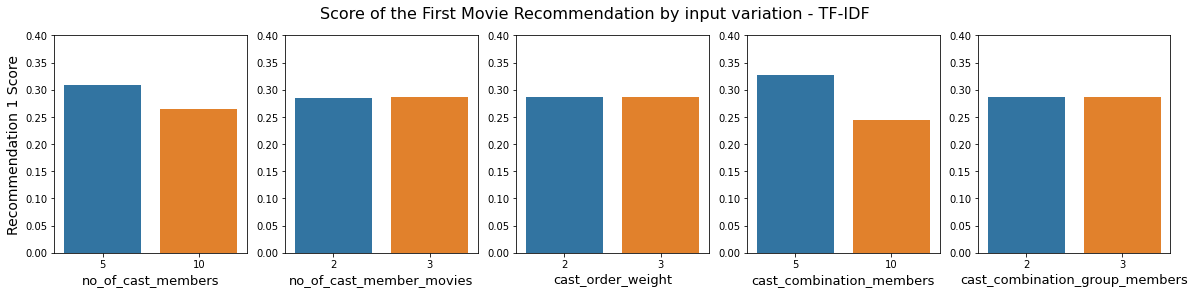

In [64]:
simulation_plot(columns_plot, 'tf-idf', results_df)

#### Conclusions
- `no_of_cast_members`: It seems that fewer members provides higher scores.
- `no_of_cast_member_movies`: No difference between 2 and 3.
- `cast_order_weight`: No difference between 2 and 3.
- `cast_combination_members`: It seems that fewer cast members in combinations provides higher scores.
- `cast_combination_group_members`: No difference between 2 and 3.

Whenever I see no difference I'll always opt for the option with the lowest computational burden.

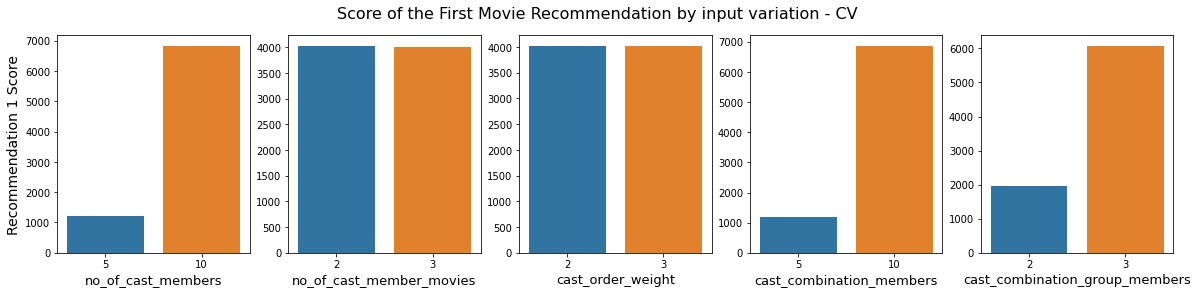

In [65]:
simulation_plot(columns_plot, 'cv', results_df)

#### Conclusions:
- It's very hard to analyze the metrics since the _scores_ are just word counts and if I add more information then I'll have more to count.

#### Count Vectorizer vs TF-IDF

Count Vectors are useful to understand the corpus by the frequency of words in it. However, the disadvantages are:
- Since CVs are just counting the number of times a word appears in the corpus, it doesn't differentiate them in anyway. As a matter of fact, the most frequent words are the most important.
- Moreover, CVs don't identify the relationships between words.

TF-IDF (Term Frequency - Inverse Document Frequency) also provides the importance of a word in the corpus. However, instead of being a simple count of words, it understands that too frequent and too rare words are less relevant. With TD-IDF it's possible to focus on words that matter, reducing the dimensionality of the problem and being more efficient. 

#### Therefore, I'm going to move forward with TF-IDF

In [66]:
# Get the title of the most voted movies
most_voted_titles = pd.merge(most_voted_movies, 
                             df_movie_info_simulation[['movieId', 'title']], 
                             on='movieId')

In [67]:
features = ['no_of_cast_members', 'no_of_cast_member_movies', 'cast_order_weight',
           'cast_combination_members', 'cast_combination_group_members']

scores_fields = [('rec_' + str(n) + '_score') for n in range(1,6)]

new_df_lst = []

for sco in scores_fields:
    temp_df = results_df[(results_df['target_title'].isin(most_voted_titles['title'])) & 
                        (results_df['algo'] == 'tf-idf')]
    temp_df = temp_df[features + [sco]]
    temp_df = temp_df.rename(columns={sco:'score'})
    temp_df['rank'] = sco
    new_df_lst.append(temp_df)
    
new_df = pd.concat(new_df_lst)
new_df = new_df.reset_index(drop=True)

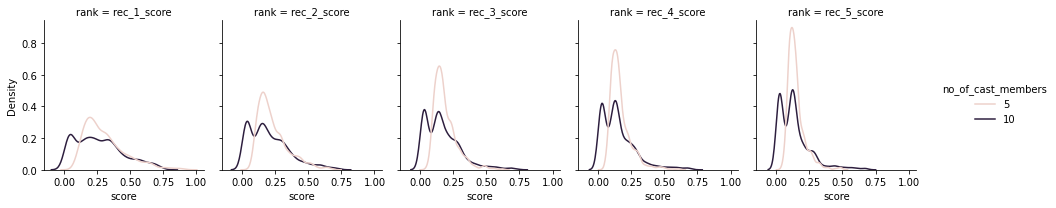

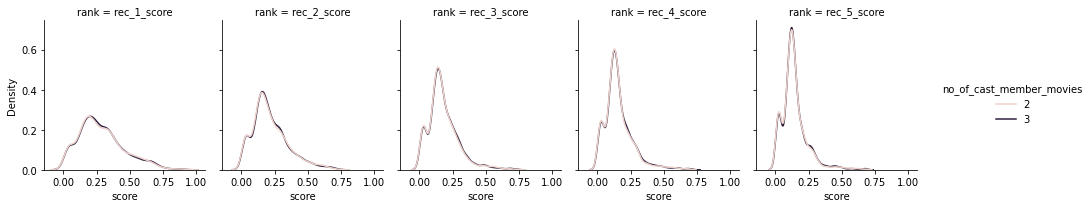

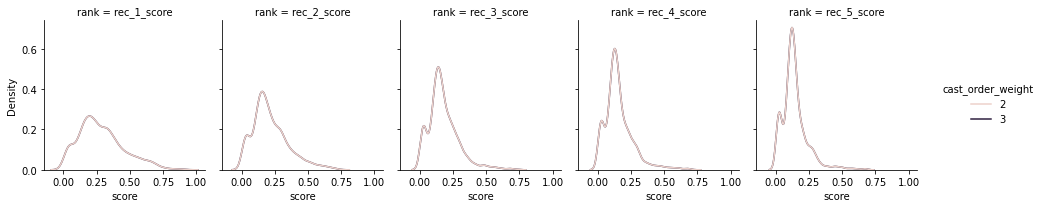

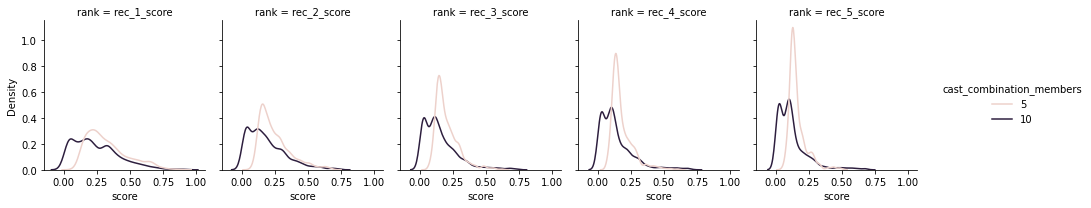

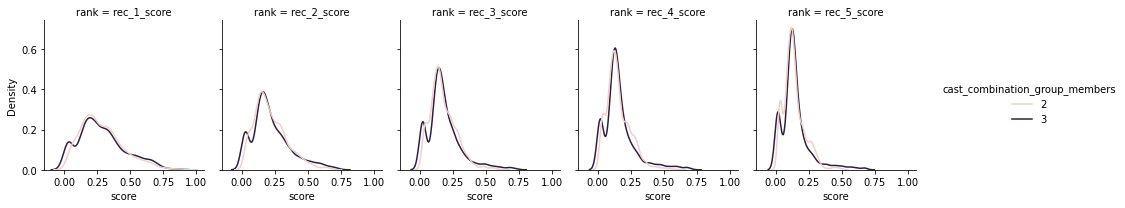

In [68]:
for feat in features:
    sns.displot(x='score',
                hue=feat,
                data=new_df,
                col='rank',
                kind='kde',
                height=3, 
                aspect=7/8)

    plt.show();

#### Conclusions
- `no_of_cast_members`: 5 shows higher scores for all recommendations (#1 to #5)
- `no_of_cast_member_movies`: No clear difference between 2 and 3.
- `cast_order_weight`: No clear difference between 2 and 3.
- `cast_combination_members`: 5 shows higher scores for all recommendations (#1 to #5)
- `cast_combination_group_members`: Distributions are very similar, no clear difference between 2 and 3.

Now, rather than looking at charts, I'm going to calculate different statistics for the first recommendation for all possible combinations of features.

In [69]:
metrics_results = []

for no_of_cast_members in [5, 10]:
    for no_of_cast_member_movies in [2, 3]:
        for cast_order_weight in [2,3]:
            for cast_combination_members in [5, 10]:
                for cast_combination_group_members in [2, 3]:
                    filtered_df = results_df[(results_df['algo'] == 'tf-idf') &
                       (results_df['no_of_cast_members'] == no_of_cast_members) &
                       (results_df['no_of_cast_member_movies'] == no_of_cast_member_movies) &
                       (results_df['cast_order_weight'] == cast_order_weight) &
                       (results_df['cast_combination_members'] == cast_combination_members) &
                       (results_df['cast_combination_group_members'] == cast_combination_group_members)]
                    
                    filtered_df = filtered_df[['rec_1_score', 'rec_2_score', 'rec_3_score']].describe()
                    filtered_df = filtered_df.transpose()
                    
                    filtered_df['no_of_cast_members'] = no_of_cast_members
                    filtered_df['no_of_cast_member_movies'] = no_of_cast_member_movies
                    filtered_df['cast_order_weight'] = cast_order_weight
                    filtered_df['cast_combination_members'] = cast_combination_members
                    filtered_df['cast_combination_group_members'] = cast_combination_group_members
                    
                    metrics_results.append(filtered_df)

In [70]:
metrics_df = pd.concat(metrics_results).reset_index()

# Ordering by the median - rec_1_score
metrics_df = metrics_df.rename(columns={'index': 'rank'})
metrics_df[metrics_df['rank'] == 'rec_1_score'].sort_values('50%', ascending=False).head()

,rank,count,mean,std,min,25%,50%,75%,max,no_of_cast_members,no_of_cast_member_movies,cast_order_weight,cast_combination_members,cast_combination_group_members
15,rec_1_score,208.0,0.341394,0.160556,0.11,0.2200,0.300,0.4325,0.86,5,2,3,5,3
3,rec_1_score,208.0,0.341394,0.160556,0.11,0.2200,0.300,0.4325,0.86,5,2,2,5,3
27,rec_1_score,208.0,0.343125,0.159759,0.11,0.2275,0.300,0.4325,0.86,5,3,2,5,3
39,rec_1_score,208.0,0.343125,0.159759,0.11,0.2275,0.300,0.4325,0.86,5,3,3,5,3
36,rec_1_score,208.0,0.339567,0.160227,0.11,0.2200,0.295,0.4300,0.87,5,3,3,5,2


In [71]:
# rec_2_score
metrics_df[metrics_df['rank'] == 'rec_2_score'].sort_values('50%', ascending=False).head()

,rank,count,mean,std,min,25%,50%,75%,max,no_of_cast_members,no_of_cast_member_movies,cast_order_weight,cast_combination_members,cast_combination_group_members
37,rec_2_score,208.0,0.259231,0.120916,0.1,0.17,0.23,0.30,0.68,5,3,3,5,2
16,rec_2_score,208.0,0.260433,0.119792,0.1,0.17,0.23,0.32,0.67,5,2,3,5,3
4,rec_2_score,208.0,0.260433,0.119792,0.1,0.17,0.23,0.32,0.67,5,2,2,5,3
25,rec_2_score,208.0,0.259231,0.120916,0.1,0.17,0.23,0.30,0.68,5,3,2,5,2
28,rec_2_score,208.0,0.262644,0.119189,0.1,0.17,0.23,0.32,0.67,5,3,2,5,3


In [72]:
# rec_3_score
metrics_df[metrics_df['rank'] == 'rec_3_score'].sort_values('50%', ascending=False).head()

,rank,count,mean,std,min,25%,50%,75%,max,no_of_cast_members,no_of_cast_member_movies,cast_order_weight,cast_combination_members,cast_combination_group_members
41,rec_3_score,208.0,0.213990,0.086689,0.09,0.15,0.19,0.25,0.62,5,3,3,5,3
29,rec_3_score,208.0,0.213990,0.086689,0.09,0.15,0.19,0.25,0.62,5,3,2,5,3
2,rec_3_score,208.0,0.209712,0.090211,0.08,0.15,0.18,0.25,0.62,5,2,2,5,2
14,rec_3_score,208.0,0.209712,0.090211,0.08,0.15,0.18,0.25,0.62,5,2,3,5,2
17,rec_3_score,208.0,0.211875,0.087138,0.08,0.15,0.18,0.25,0.62,5,2,3,5,3


`rec_1_score`:
> Looking at `std` and `25%` I'm inclined to choose the third row in the dataframe above. First because it has a higher `25%` than the first ones and second because it has a lower `std`, so the scores are slighly more consistent and not as disperse (_I know the difference is minimal, but it's better_).

`rec_2_score`:
> Metrics are very close, so the decision is somewhat questionable. Nonetheless, I'm going to go for low `std` and high `mean` which gives me a similar results to `rec_1_score`.

`rec_3_score`:
> Metrics are very close again. I'm going to focus on high mean, low `std` and high `mean`. Again, the result coincides with `rec_1_score`'s.

#### Best inputs:
- `algo`: `tf-idf`
- `no_of_cast_members`: 5
- `no_of_cast_member_movies`: 3
- `cast_order_weight`: 2
- `cast_combination_members`: 5
- `cast_combination_group_members`: 3

#### Check some recommendations

In [73]:
# Get recommendations for the chosen inputs
recommendations = simulation(no_of_cast_members=5,
                             no_of_cast_member_movies=3,
                             cast_order_weight=2,
                             cast_combination_members=5,
                             cast_combination_group_members=3)

In [74]:
recommendations[recommendations['algo'] == 'tf-idf'][['target_title', 
                                                      'rec_1_title', 'rec_1_score', 
                                                      'rec_2_title', 'rec_2_score', 
                                                      'rec_3_title', 'rec_3_score', 
                                                      'rec_4_title', 'rec_4_score', 
                                                      'rec_5_title', 'rec_5_score']].sort_values('target_title')\
                                                               .set_index('target_title')

,rec_1_title,rec_1_score,rec_2_title,rec_2_score,rec_3_title,rec_3_score,rec_4_title,rec_4_score,rec_5_title,rec_5_score
target_title,,,,,,,,,,
"Dark Knight, The","Dark Knight Rises, The",0.59,Batman Begins,0.45,"Prestige, The",0.38,Interstellar,0.27,Memento,0.25
Fight Club,Seven (a.k.a. Se7en),0.14,"Curious Case of Benjamin Button, The",0.13,Zodiac,0.12,Choke,0.11,Panic Room,0.11
Forrest Gump,The Post,0.47,Live Free or Die Hard,0.34,J. Edgar,0.33,Pawn Sacrifice,0.31,"Rum Diary, The",0.29
"Godfather, The","Godfather: Part III, The",0.35,"Godfather: Part II, The",0.32,Apocalypse Now,0.26,"Cotton Club, The",0.26,Christopher Columbus: The Discovery,0.20
"Matrix, The","Matrix Reloaded, The",0.51,"Matrix Revolutions, The",0.45,Red Planet,0.31,Silent Hill: Revelation 3D,0.30,Unthinkable,0.28
Pulp Fiction,Reservoir Dogs,0.39,The Hateful Eight,0.30,True Romance,0.29,Django Unchained,0.21,Jackie Brown,0.19
"Shawshank Redemption, The","Mist, The",0.34,"Green Mile, The",0.29,"Blob, The",0.18,Dreamcatcher,0.17,Mary Shelley's Frankenstein (Frankenstein),0.14
Toy Story,"Bug's Life, A",0.38,Toy Story 3,0.35,Toy Story 2,0.31,WALL·E,0.26,Cars,0.19
"Usual Suspects, The",Valkyrie,0.30,Jack the Giant Slayer,0.28,"Way of the Gun, The",0.23,Superman Returns,0.18,Swimming with Sharks,0.15


I'm happy with the results. Probably I should also consider the score values and set a threshold because some of the recommendations have low scores compared to others. I'm not going to do that now. I'll perform the analysis once I get to build the final/hybrid model.

#### Create final content-based model
Rather than using the model above I'm going to create a new one that will be used in the hybrid model. I'm changing the output format and using only TF-IDF.

In [75]:
def content_based_model(no_of_cast_members,
                        no_of_cast_member_movies,
                        cast_order_weight,
                        cast_combination_members,
                        cast_combination_group_members,
                        df_movie_info_simulation=df_movie_info_simulation,
                        df_movie_cast_simulation=df_movie_cast_simulation):
    
    # Keep only cast members in more than one movie
    cast_count = df_movie_cast_simulation.groupby('cast_name').count()['movieId'].reset_index()
    cast_count.columns = ['cast_name', 'count']
    cast_name_filtered = list(cast_count[cast_count['count'] > no_of_cast_member_movies]['cast_name'])
    cast_name_filtered = set(cast_name_filtered)
    df_filtered_cast = df_movie_cast_simulation[df_movie_cast_simulation['cast_name'].isin(cast_name_filtered)]
    
    # Create a new column with new order
    df_filtered_cast['new_order'] = df_filtered_cast.groupby('movieId').rank()['cast_order']

    # After reviewing different casts I'm going to keep the first no_of_cast_members cast members
    # I found that to be a good number
    df_filtered_cast = df_filtered_cast[df_filtered_cast['new_order'] < no_of_cast_members]
    
    # Define multiplier weight value
    cast_order_multiplier_value = no_of_cast_members // cast_order_weight 
    
    # Create Multiplier to give top cast members more weight
    df_filtered_cast['multiplier'] = cast_order_multiplier_value - \
                                    (df_filtered_cast['new_order'] // cast_order_weight)
    df_filtered_cast['clean_cast_name'] = df_filtered_cast['cast_name'].str.lower().str.replace(' ', '')
    df_filtered_cast['weighted_cast'] = df_filtered_cast.apply(lambda x: (x['clean_cast_name'] + ' ') 
                                                               * int(x['multiplier'])
                                                               , axis=1)
    
    # Come up with cast combinations
    df_movie_cast_combinations = df_filtered_cast.groupby('movieId')\
                                                 .apply(lambda x: cast_combinations(x, 
                                                                                    cast_combination_members,
                                                                                    cast_combination_group_members))
    df_movie_cast_combinations = df_movie_cast_combinations.reset_index()
    df_movie_cast_combinations.columns = ['movieId', 'cast_combinations']

    # Create a column with weighted cast
    df_movie_cast_modified = df_filtered_cast.groupby('movieId')['weighted_cast']\
                                             .apply(lambda x: ' '.join(x))\
                                             .reset_index()
    
    df_movie_cast_modified = pd.merge(df_movie_info_simulation.drop('weighted_cast', axis=1),
                                      df_movie_cast_modified, on='movieId')


    df_movie_info_simulation['all_content_features'] = (df_movie_info_simulation['weighted_cast'] + ' ' +
                                                        df_movie_info_title['title'] + ' ' +
                                                        df_movie_info_title['movie_description'] + ' ' +
                                                        df_movie_info_title['movie_plot'] + ' ' +
                                                        df_movie_info_title['movie_keywords'])
    
    df_movie_info_simulation = pd.merge(df_movie_info_simulation.drop('cast_combinations', axis=1), 
                                        df_movie_cast_combinations[['movieId', 'cast_combinations']], 
                                        on='movieId')
    
    df_movie_info_simulation['all_content_features'] = (df_movie_info_simulation['all_content_features'] + ' ' +
                                                        df_movie_info_simulation['cast_combinations'])
    
    # Fit the model - TF-IDF and CountVectorizer
    tf = TfidfVectorizer(analyzer='word', 
                         ngram_range=(1, 2), 
                         min_df=0, 
                         stop_words='english')

    tfidf_matrix = tf.fit_transform(df_movie_info_simulation['all_content_features'])
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
    
    df_cosine_sim = pd.DataFrame(cosine_sim)
    df_cosine_sim.columns = df_movie_info_simulation['movieId'].to_list()
    df_cosine_sim = pd.merge(df_cosine_sim, 
                              df_movie_info_simulation[['movieId']],
                              right_index=True,
                              left_index=True)
                   
    return df_cosine_sim

In [76]:
def get_recommendations_content(title, df_cosine_sim, df_movie_info_simulation):
    # Grab the movieId from dataframe
    target_movieId = df_movie_info_simulation.loc[df_movie_info_simulation['title'] == title]['movieId']
    target_movieId = target_movieId.values[0]
    
    # Extract scores and sort them
    if target_movieId in df_cosine_sim['movieId'].to_list():
        target_row = df_cosine_sim[df_cosine_sim['movieId'] == target_movieId]
        target_row = target_row.transpose().reset_index().iloc[:-1]
        target_row.columns = ['movieId', 'score']
        target_row = target_row.sort_values('score', ascending=False).iloc[1:]

        # Keep only top 5 recommendations and return that
        df_reco = target_row[target_row['score'] > 0].iloc[:5].reset_index(drop=True)

        # Create dataframe with recommendations
        df_reco['movie_target_name'] = title
        df_reco['movie_target_movieId'] = target_movieId
        df_reco = df_reco.reset_index()
        df_reco = df_reco.rename(columns={'index': 'rec_n'})

        return df_reco

In [77]:
# Extract trained model
content_model = content_based_model(no_of_cast_members=5,
                                    no_of_cast_member_movies=3,
                                    cast_order_weight=2,
                                    cast_combination_members=5,
                                    cast_combination_group_members=3)

In [78]:
# Test the output
get_recommendations_content('Toy Story', content_model, df_movie_info_simulation)

,rec_n,movieId,score,movie_target_name,movie_target_movieId
0,0,2355,0.377201,Toy Story,1
1,1,78499,0.348608,Toy Story,1
2,2,3114,0.312099,Toy Story,1
3,3,60069,0.255575,Toy Story,1
4,4,45517,0.193780,Toy Story,1




## Collaborative-Based Filtering <a class="anchor" id="colab"></a>

Collaborative Filtering is based on the idea that users similar to a me can be utilized to predict how much I will like a particular product or service that those same users have used/experienced but I have not.

The strategy is to use different models and compare their performances. The metric to optimize for is RMSE. However, most likely, the best model will be the Singular Value Decomposition (SVD) or SVD++ based on what I have seen in different places. Nonetheless, I think it's worth trying different models rather than simply trying only these two models.

Moreover, I'm also considering the fit time, otherwise, I might end up with a model that would not be _deployable_.

In [79]:
# Create a new dataframe to train the model.
df_ratings_clean = df_ratings[['userId', 'movieId', 'rating']]

#### Reduce dataset to decrease runtime

The dataset is too big and it's going to take too long to train the models if I use the whole dataset (_I've learned that the hard way_). Therefore, I'm picking only 50% of it to identify the best hyperparameters for the SVD model and I'm running GridSearchCV only for 50% of that. Once I identify the best hyperparameters, I'll then train the model using the whole dataset.

In [80]:
# Randomly pick 50,000 datapoints fmor the dataset
sample_df = df_ratings_clean.sample(n=50000, random_state=111)

# Split the sample data in two so I can test the best hyperparameters later on
train_df, test_df = train_test_split(sample_df, train_size=.50, random_state=111)

# Create reader and dataset objects
reader = Reader()
traindata = Dataset.load_from_df(train_df, reader)
testdata = Dataset.load_from_df(test_df, reader)

### GridSearchCV - Hyperparameter Tunning of SVD <a class="anchor" id="grid"></a>
**[Go back to Table of Contents](#toc)**

In [81]:
# Perform a gridsearch with SVD
param_grid = {'n_factors':[10, 15, 20]
              , 'n_epochs': [10, 20]
              , 'lr_all': [0.008, 0.012]
              , 'reg_all': [0.06, 0.1]
              , 'random_state': [111]}

gs_model = GridSearchCV(SVD, param_grid=param_grid, n_jobs = -1, joblib_verbose=False)

%time gs_model.fit(traindata)

CPU times: user 44.6 s, sys: 1.04 s, total: 45.6 s
Wall time: 47.6 s


In [82]:
print('The best parameters are:')
gs_model.best_params['rmse']

The best parameters are:


{'n_factors': 15,
 'n_epochs': 20,
 'lr_all': 0.008,
 'reg_all': 0.1,
 'random_state': 111}

### GridSearchCV Metrics Analysis
Let's analyze the metrics of each run and pick the best parameters given the RMSE and Fit Time. Sometimes simply choosing the best parameters is not the best option since the only goal of the Grid is to minimize RMSE. We should also consider the Fit Time if we are planning on having this model as a service running online.

In [83]:
# Convert results from the GridSearchCV to dataframes
df_params = pd.DataFrame(gs_model.cv_results['params'])
df_rmse = pd.DataFrame(gs_model.cv_results['mean_test_rmse'], columns=['mean_test_rmse'])
df_time = pd.DataFrame(gs_model.cv_results['mean_fit_time'], columns=['mean_fit_time'])
df_results = pd.concat([df_params, df_rmse, df_time], axis=1)

Create a function to print metrics so we can see the impact of hyperparameters in RMSE and Fit Time.

In [84]:
def compare_metrics_chart(df, column_a, column_b):
    """
    Function to plot the comparison of two metrics in a GridSearchCV run.
    
    Args:
        df(pd.Dataframe): Pandas Dataframe with GridSearchCV metrics.
        column_a(str): First metric
        column_b(str): Second Metric
    """
    # Create Figure
    fig = plt.figure(figsize=(10,5))
    
    # Create first axis
    ax = fig.add_subplot(111)
    # Plot Column A
    sns.lineplot(data=df[column_a], color="g", ax=ax)
    # Set Y Label
    ax.set_ylabel(column_a, color='g', size=10)
    
    # Create axis 2
    ax2 = plt.twinx()
    # Plot Column B
    sns.lineplot(data=df[column_b], color="b", ax=ax2)
    # Set Y Label
    ax2.set_ylabel(column_b, color='b', size=10)
    
    # Change the format of the title
    column_a_title = column_a.replace('_', ' ').title()
    column_b_title = column_b.replace('_', ' ').title()
    plt.title(column_a_title + ' vs. ' + column_b_title)
    
    plt.show();

#### Number of Factors

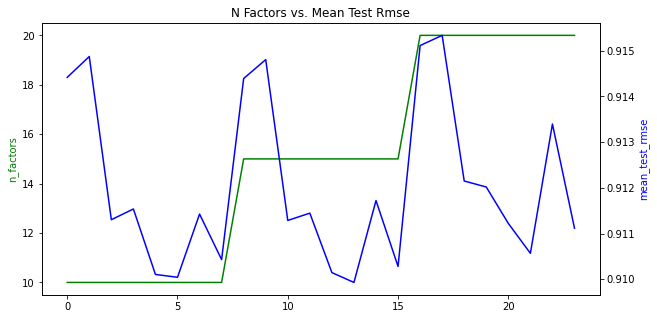

In [85]:
compare_metrics_chart(df_results, 'n_factors', 'mean_test_rmse')

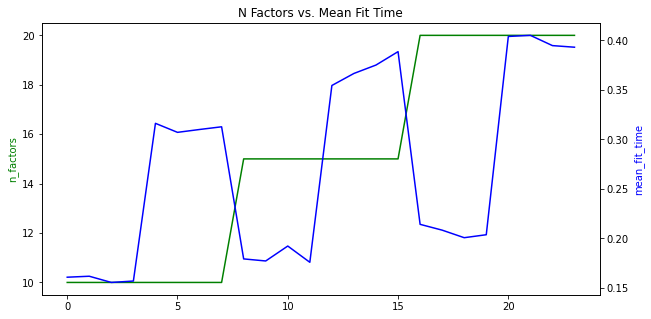

In [86]:
compare_metrics_chart(df_results, 'n_factors', 'mean_fit_time')

The lowest values for RMSE is reached regardless of the Number of Factors. It's arguable that we should have more factors to decrease RMSE since that's the expectation. However, it comes at a cost: fit time increase. Since the data is showing we can achieve low RMSE with only `10` factors then I'm going to choose that.

#### Number of Epochs

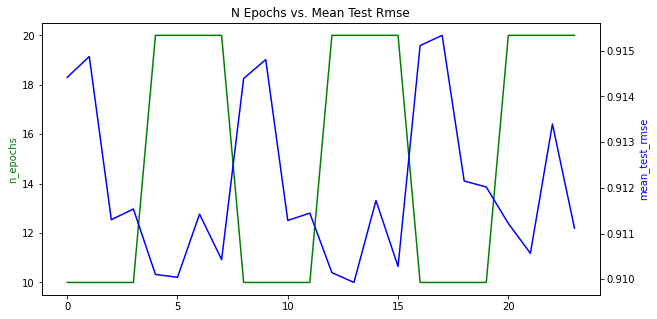

In [87]:
compare_metrics_chart(df_results, 'n_epochs', 'mean_test_rmse')

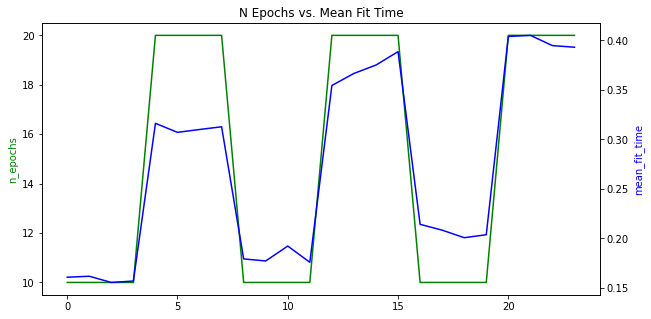

In [88]:
compare_metrics_chart(df_results, 'n_epochs', 'mean_fit_time')

The Number of Epochs reduces RMSE, but it's possible to see an increase of 50%-80% in Fit Time, which is more than the positive impact in RMSE. Therefore, I'll go with `20` epochs. 

#### Regularization Term

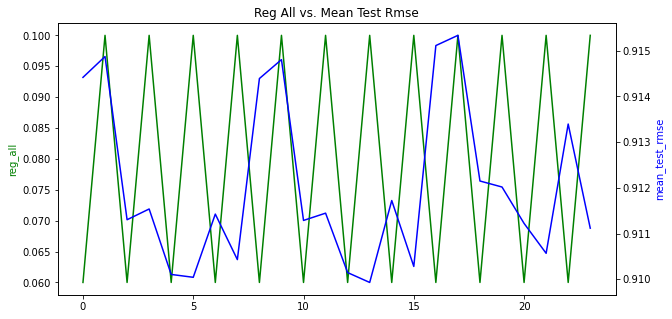

In [89]:
compare_metrics_chart(df_results, 'reg_all', 'mean_test_rmse')

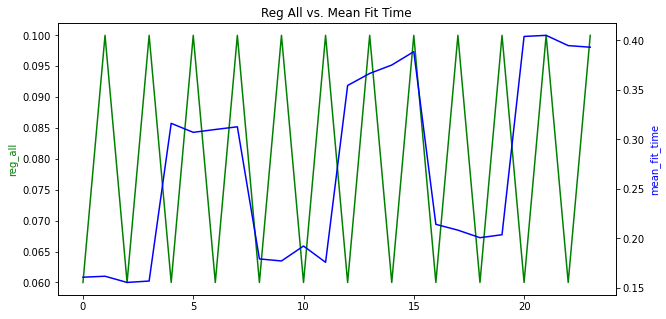

In [90]:
compare_metrics_chart(df_results, 'reg_all', 'mean_fit_time')

Low regularization term achieves better results with no impact in fit time.

#### Learning Rate

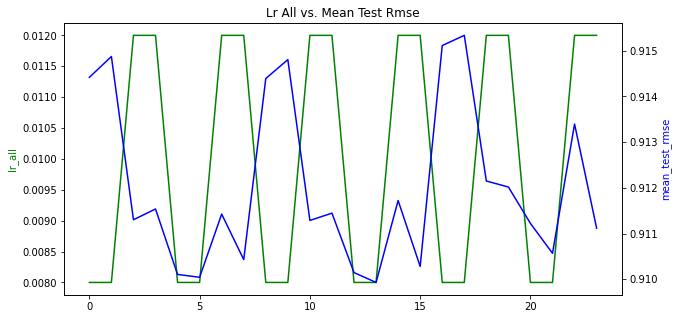

In [91]:
compare_metrics_chart(df_results, 'lr_all', 'mean_test_rmse')

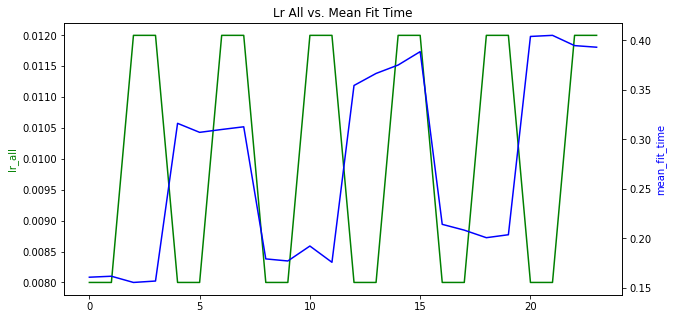

In [92]:
compare_metrics_chart(df_results, 'lr_all', 'mean_fit_time')

Having high Learning Rate has a positive impact in RMSE with now impact in Fit Time.

#### Final hyperparameters:
- `n_factors`: 15
- `n_epochs`: 20
- `lr_all`: 0.012
- `reg_all`: 0.06

**[Go back to Table of Contents](#toc)**

### Try different models <a class="anchor" id="dif"></a>
#### Create a function to easily test different models

In [93]:
def full_model_training_evaluation(model, model_name, traindata, testdata):
    """
    Train and test different models and collect fit time and train/test RMSE.
    
    Args:
        model(surprise.prediction_algorithms): Model instances from the surprise package.
        model_name(str): Model name created by the User. A way to identify the model.
        traindata(surprise.dataset.DatasetAutoFolds): Train dataset
        testdata(surprise.dataset.DatasetAutoFolds): Test dataset
        
    Returns:
        results(dict): A dictionary with the model name, fit time and RMSE's (train/test).
    """
    # Stor results in dictionary
    results = {}
    results['model_name'] = model_name
    print('Training', model_name, 'model')
    
    # Fit on train data
    start_time = time.time()
    model.fit(traindata.build_full_trainset())
    end_time = time.time()
    total_time = round(end_time - start_time, 2)
    results['fit_time_in_seconds'] = total_time
    
    # Get RMSE on train data
    predictions_train = model.test(traindata.build_full_trainset().build_testset())
    rmse_train = rmse(predictions_train, verbose=False).round(2)
    results['rmse_train'] = rmse_train
    
    # Get RMSE on test data
    predictions_test = model.test(testdata.build_full_trainset().build_testset())
    rmse_test = rmse(predictions_test, verbose=False).round(2)
    results['rmse_test'] = rmse_test
    
    return results

Instantiate different models

In [94]:
# Create SVD model with the best hyperparameters
svd = SVD(n_factors=15, n_epochs=20, lr_all=0.012, reg_all=0.06, random_state=111)

In [95]:
# SVD++: Use the same hyperparameters
svd_pp = SVDpp(n_factors=15, n_epochs=20, lr_all=0.012, reg_all=0.06, random_state=111)

In [96]:
# Different instances of KNN Basic models with different hyperparameters
knn_basic_person_baseline = KNNBasic(sim_options={'name':'pearson_baseline', 'user_based':True}, verbose=False)
knn_basic_person = KNNBasic(sim_options={'name':'pearson', 'user_based':True}, verbose=False)
knn_basic_cosine = KNNBasic(sim_options={'name':'cosine', 'user_based':True}, verbose=False)

In [97]:
# Different instances of KNN Baseline models with different hyperparameters
knn_base_person_baseline = KNNBaseline(sim_options={'name':'pearson_baseline', 'user_based':True}, verbose=False)
knn_base_person = KNNBaseline(sim_options={'name':'pearson', 'user_based':True}, verbose=False)
knn_base_cosine = KNNBaseline(sim_options={'name':'cosine', 'user_based':True}, verbose=False)

In [98]:
# Put all models in a dictionary
models = {'SVD': svd,
          'SVD++': svd_pp,
          'KNNBasic Cosine': knn_basic_cosine,
          'KNNBasic Person': knn_basic_person,
          'KNNBasic Person Baseline': knn_basic_person_baseline,
          'KNNBaseline Cosine': knn_base_cosine,
          'KNNBaseline Person': knn_base_person,
          'KNNBaseline Person Baseline': knn_base_person_baseline}

In [99]:
# Loop through different models and evaluate them
model_results = []

for model_name, model_instance in models.items():
    results = full_model_training_evaluation(model_instance, model_name, traindata, testdata)
    model_results.append(results)

Training SVD model
Training SVD++ model
Training KNNBasic Cosine model
Training KNNBasic Person model
Training KNNBasic Person Baseline model
Training KNNBaseline Cosine model
Training KNNBaseline Person model
Training KNNBaseline Person Baseline model


**[Go back to Table of Contents](#toc)**

### Model Evaluation <a class="anchor" id="eval"></a>

In [100]:
pd.DataFrame(model_results)

,model_name,fit_time_in_seconds,rmse_train,rmse_test
0,SVD,0.66,0.70,0.90
1,SVD++,35.09,0.65,0.90
2,KNNBasic Cosine,0.11,0.80,1.04
3,KNNBasic Person,0.17,0.54,1.08
4,KNNBasic Person Baseline,0.13,0.09,1.09
5,KNNBaseline Cosine,0.17,0.73,0.94
6,KNNBaseline Person,0.21,0.47,0.97
7,KNNBaseline Person Baseline,0.15,0.08,0.98


#### Notes:
- **Fit Time**: `SVD++` is by far the worst model. All KNN models have somewhat the same Fit Time, which is 4 times faster than `SVD`. However, they are all very fast relative to the `SVD++` model.
- **RMSE Train**: The KNN Models using `person_baseline` is overfitting the train set. When comparing both Singular Value Decomposition models, the `SVD++` is performing better than the `SVD`.
- **RMSE Test**: Both Singular Value Decomposition models had the same performance numbers and performed better than all KNN models.

### Conclusion
I'll move forward with the `SVD` model given the fit time and RMSE scores.

**[Go back to Table of Contents](#toc)**

## Create function to take user input and give recommendations (+ hint of content-based attribute) <a class="anchor" id="func"></a>
Finally, I'm going to create a function that takes a genre and ratings from a user who has no ratings in the dataset. In the process, I'm going to focus my recommendations based on the chosen genre (content-based part of the recommendation).

In [101]:
# Create list of genres
list_of_genres = stacked_genres['genre'].sort_values().unique()[1:]

In [102]:
# Combine mean ratings and movies details
ratings_movies_df = pd.merge(mean_ratings_df, df_movies, on='movieId')

#### Filter the dataset by removing movies with not enough ratings

In [103]:
def filtered_dataset(genre):
    """
    Function to filter the dataset given the genre and remove outliers.
    
    Args:
        genre(str): The genre the user has chosen to come with recommendations.
        
    Returns:
        genre_df(pd.DataFrame): Filtered Dataframe with only the chosen genre.
    """
    # Keep only the selected genre
    genre_df = ratings_movies_df[ratings_movies_df['genres'].str.contains(genre)]
    
    # Calculate the 95th quantile and the weighted rating
    minimum_no_of_ratings = genre_df['count_rating'].quantile(0.95)
    genre_df['minimum_no_of_ratings'] = minimum_no_of_ratings
    genre_df['weighted_rating'] = genre_df.apply(weighted_rating, axis=1)
    
    # Remove movies with not enough ratings
    genre_df = genre_df[genre_df['count_rating'] >= minimum_no_of_ratings]
    
    # Sorted it by weighted rating so we have the highest ratings on the top
    genre_df = genre_df.sort_values('weighted_rating', ascending=False)
    genre_df = genre_df.reset_index(drop=True)

    # Keep certain relevant columns
    genre_df = genre_df[['movieId', 'title', 
                         'genres', 'count_rating', 
                         'minimum_no_of_ratings', 'weighted_rating']]

    return genre_df

#### Create first a function to let the user rate five movies

In [104]:
def rate_movie(n_of_movies=5, default_user_id=9999999):
    """
    Function to request a new user to review some movies.
    
    Args:
        n_of_movies(int): Number of ratings the new will have to give.
        default_user_id(int): Random user id that will be given to the user to be able to reference to it later.
        
    Returns:
        new_ratings_df(pd.DataFrame): Pandas Dataframe with the new ratings
        favorite_genre(str): The User's favorite genre
    """
    # Print a list of the available genres
    print('List of Available Genres: ', ", ".join(list_of_genres))
    
    # Gather input from user on which genre will be analyzed
    favorite_genre = input('Choose one genre from the following (case-sensitive): ')
    
    # Filter the dataset
    df_movies_popularity = filtered_dataset(favorite_genre)
    
    # Keep only movies that contain the chosen genre
    favorite_genre_movies = df_movies_popularity[df_movies_popularity['genres'].str.contains(favorite_genre)]
    
    # Keep the highest rated movies
    favorite_genre_movies = favorite_genre_movies.iloc[:20].sample(frac=1, random_state=111)
    favorite_genre_movies = favorite_genre_movies.iloc[:n_of_movies]
    print('')
    
    # Created to store ratings from user
    ratings_list = []
    
    # Loop through dataframe with movies to be rated
    for row in favorite_genre_movies.iterrows():
        # Extract Title and ID
        movie_title = row[1]['title']
        movie_id = row[1]['movieId']
        
        print('Movie to rate: ', movie_title)
        
        # Gather rating from user
        rating = input('How do you rate this movie on a scale of 1-5, press n if you have not seen :\n')
        
        # Deal with users not typing a number and create a new variable with the integer
        try:
            rating_int = int(rating)
        except:
            rating_int = 1
        
        # While the Rating is not valid, keep asking the user
        while (rating != 'n') and not (1 <= rating_int <=5):
            rating = input('Please rate the movie between 1-5 or n if you have not seen : \n')
        else:
            # If the rating is different from 'n' then we need to add the rating to the list
            if rating != 'n':        
                ratings_list.append({'userId': default_user_id,
                                    'movieId': movie_id,
                                    'rating': rating_int})
        print('')
        
    # Convert to DataFrame
    new_ratings_df = pd.DataFrame(ratings_list)
    
    return new_ratings_df, favorite_genre, df_movies_popularity

#### Create a function to give the recommendations

In [105]:
def give_n_recommendations(model, default_user_id=9999999, n_recommendations=5):
    """
    Function to request a new user to review movies and give recommendations based on that.
    
    Args:
        model(surprise.prediction_algorithms): Model instances from the surprise package.
        default_user_id(int): Random user id that will be given to the user to be able to reference to it later.
        n_recommendations(int): Number of recommendations that will be given to the user.
    """
    # Extract ratings from the user
    new_ratings_df, favorite_genre, df_movies_popularity = rate_movie(default_user_id=default_user_id)
    watched_movies_id = new_ratings_df['movieId']
    
    # add the new ratings to the original ratings DataFrame
    updated_df = pd.concat([new_ratings_df, df_ratings_clean])
    new_data = Dataset.load_from_df(updated_df, reader)
    new_dataset = new_data.build_full_trainset()
    
    # Fit new dataset
    model.fit(new_dataset)
    
    # make predictions for the user
    results = []
    for movie_id in df_movies_popularity['movieId'].unique():
        predicted_score = model.predict(default_user_id, movie_id)[3]
        results.append((movie_id, predicted_score))
        
    # order the predictions from highest to lowest rated
    ranked_movies = pd.DataFrame(results, columns=['movieId', 'predicted_score'])
    ranked_movies = ranked_movies[~ranked_movies['movieId'].isin(watched_movies_id)]
    ranked_movies = ranked_movies.sort_values('predicted_score', ascending=False).reset_index(drop=True)
    ranked_movies = pd.merge(ranked_movies, df_movies, on='movieId')
    # ranked_movies = ranked_movies[ranked_movies['genres'].str.contains(favorite_genre)]
    
    print('The recommendations are the following:')
    if len(ranked_movies) < n_recommendations:
        n_recommendations = len(ranked_movies)
    for row in range(n_recommendations):
        movie_id = ranked_movies.iloc[row]['movieId']
        recommended_title = df_movies[df_movies['movieId'] == movie_id]['title'].item()
        print(f'Number {row+1} is {recommended_title}')

#### Let's test it out!
I'm going to try different genres to see how the model behaves.
#### `Action`

In [106]:
give_n_recommendations(svd)

List of Available Genres:  Action, Adventure, Animation, Children, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, IMAX, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western

Movie to rate:  Star Wars: Episode V - The Empire Strikes Back (1980)

Movie to rate:  Dark Knight, The (2008)

Movie to rate:  Inception (2010)

Movie to rate:  Apocalypse Now (1979)

Movie to rate:  Blade Runner (1982)

The recommendations are the following:
Number 1 is Fight Club (1999)
Number 2 is Dark Knight Rises, The (2012)
Number 3 is Lord of the Rings: The Return of the King, The (2003)
Number 4 is Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
Number 5 is Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966)


#### `Romance`

In [107]:
give_n_recommendations(svd)

List of Available Genres:  Action, Adventure, Animation, Children, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, IMAX, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western

Movie to rate:  Casablanca (1942)

Movie to rate:  American Beauty (1999)

Movie to rate:  Shrek (2001)

Movie to rate:  Graduate, The (1967)

Movie to rate:  Lost in Translation (2003)

The recommendations are the following:
Number 1 is Life Is Beautiful (La Vita è bella) (1997)
Number 2 is WALL·E (2008)
Number 3 is Princess Bride, The (1987)
Number 4 is Eternal Sunshine of the Spotless Mind (2004)
Number 5 is North by Northwest (1959)


# Hybrid Model

In [108]:
df_movie_info_title[df_movie_info_title['title'].astype(str).str.contains('Notebook')]

,movieId,weighted_cast,title,movie_description,movie_plot,movie_keywords,cast_combinations
3030,8533,nickcassavetes nickcassavetes nickcassavetes n...,"Notebook, The","In a nursing home, resident Duke reads a roman...",A poor yet passionate young man falls in love ...,class differences letter second chance summer ...,jeremylevennickcassavetes jansardinickcassavet...


In [109]:
favorite_movies = ['Inception', 
                   'Pulp Fiction']

# favorite_movies = ['Hidden Figures',
#                   'Moneyball',
#                   'Django Unchained',
#                   'Titanic',
#                   'Notebook, The',
#                   'The Hateful Eight',
#                   'Inglourious Basterds']

favorite_movieIds = df_movie_info_title[df_movie_info_title['title'].isin(favorite_movies)]['movieId']

In [110]:
def collect_content_recommendations(favorite_movies=favorite_movies,
                                   content_model=content_model,
                                   df_movie_info_simulation=df_movie_info_simulation):
    
    # Run content related recommendations
    content_recos = []

    for fav in favorite_movies:
        content_recos.append(get_recommendations_content(fav, content_model, df_movie_info_simulation))
    
    # Create a dataframe of and bring the title
    content_recos_df = pd.concat(content_recos)
    content_recos_df = pd.merge(content_recos_df,
                                df_movie_info_title[['movieId', 'title']],
                                on='movieId')
    
    # Make sure I'm not recommending one of the favorite movies
    content_recos_df = content_recos_df[(~content_recos_df['title'].isin(favorite_movies))]
    
    # Sort dataframe by 'score' and calculate the max score and the number of times the same movie was
    # recommended
    content_recos_df = content_recos_df.sort_values('score', ascending=False).reset_index(drop=True)
    count_of_times = content_recos_df.groupby('movieId').agg({'score': ['max','count']}).reset_index()
    count_of_times.columns = ['movieId', 'max_score', 'no_of_times']
    
    # Keep only one recommendation for the same movie
    content_recos_df = pd.merge(content_recos_df, count_of_times, on='movieId')
    content_recos_df = content_recos_df.drop_duplicates('movieId', keep='first')
    
    # Keep only max two recommendations for the same movie
    content_recos_df['rank'] = content_recos_df.groupby('movie_target_movieId').rank()['rec_n']
    
    return content_recos_df

In [111]:
def collect_collaborative_recommendations(ratings_movies_df=ratings_movies_df,
                                          favorite_movieIds=favorite_movieIds,
                                          df_ratings_clean=df_ratings_clean,
                                          svd=svd,
                                          default_user_id = 9999999):
    
    # Create copy of the dataframe to work with
    genre_df = ratings_movies_df.copy()

    # Calculate the 80th quantile and the weighted rating
    minimum_no_of_ratings = genre_df['count_rating'].quantile(0.80)
    genre_df['minimum_no_of_ratings'] = minimum_no_of_ratings
    genre_df['weighted_rating'] = genre_df.apply(weighted_rating, axis=1)

    # Remove movies with not enough ratings
    genre_df = genre_df[genre_df['count_rating'] >= minimum_no_of_ratings]

    # Sorted it by weighted rating so we have the highest ratings on the top
    genre_df = genre_df.sort_values('weighted_rating', ascending=False)
    genre_df = genre_df.reset_index(drop=True)
    
    # Add ratings from the user (assume they ratings are all 5)
    ratings_list = []
    
    for watched in favorite_movieIds:
        ratings_list.append({'userId': default_user_id,
                             'movieId': watched,
                             'rating': 5})

    # Convert to DataFrame
    new_ratings_df = pd.DataFrame(ratings_list)

    # add the new ratings to the original ratings DataFrame
    updated_df = pd.concat([new_ratings_df, df_ratings_clean])
    new_data = Dataset.load_from_df(updated_df, reader)
    new_dataset = new_data.build_full_trainset()

    # Fit new dataset
    svd.fit(new_dataset)

    # make predictions for the user
    results = []
    for movie_id in genre_df['movieId'].unique():
        predicted_score = svd.predict(default_user_id, movie_id)[3]
        results.append((movie_id, predicted_score))

    # order the predictions from highest to lowest rated
    ranked_movies = pd.DataFrame(results, columns=['movieId', 'predicted_score'])
    ranked_movies = ranked_movies[~ranked_movies['movieId'].isin(new_ratings_df['movieId'])]
    ranked_movies = ranked_movies.sort_values('predicted_score', ascending=False).reset_index(drop=True)
    ranked_movies = pd.merge(ranked_movies, df_movies, on='movieId')
    
    return ranked_movies

In [112]:
def hybrid_model(favorite_movies=favorite_movies,
                 content_model=content_model,
                 df_movie_info_simulation=df_movie_info_simulation,
                 ratings_movies_df=ratings_movies_df,
                 df_ratings_clean=df_ratings_clean,
                 svd=svd,
                 collaborative_weight=0.5,
                 content_weight=0.5):
    
    # Get recommendations from content-based model
    content_recos_df = collect_content_recommendations(favorite_movies,
                                                       content_model,
                                                       df_movie_info_simulation)
    
    # Get recommendations from collaborative-based model
    ranked_movies = collect_collaborative_recommendations(ratings_movies_df,
                                                          content_recos_df,
                                                          df_ratings_clean,
                                                          svd)
    
    # Combine dataframes
    combined_df = pd.merge(content_recos_df, 
                           ranked_movies[['movieId', 'predicted_score']],
                           on='movieId')
    
    # Normalize collaborative score
    combined_df['norm_collaborative_score'] = np.log(combined_df['predicted_score'])
    
    # Scale collaborative score
    combined_df['scaled_collaborative_score'] = (
        (combined_df['norm_collaborative_score'] - combined_df['norm_collaborative_score'].min()) / 
        (combined_df['norm_collaborative_score'].max() - combined_df['norm_collaborative_score'].min()))
    
    # Add more weight to movies that were recommended multiple times
    combined_df['no_of_times_score'] = combined_df['max_score'] * (1 + ((combined_df['no_of_times'] - 1) / 10))
    
    # Consider the rank of the recommendation to avoid recommending a bunch of movies for the same target
    combined_df['ranked_score'] = combined_df['no_of_times_score'] * (1 - ((combined_df['rank'] - 1) / 10))
    
    # Normalize content score
    combined_df['norm_content_score'] = np.log(combined_df['ranked_score'])
    
    # Scale the content score
    combined_df['scaled_content_score'] = (
        (combined_df['norm_content_score'] - combined_df['norm_content_score'].min()) / 
        (combined_df['norm_content_score'].max() - combined_df['norm_content_score'].min()))
    
    # Combine both content + collaborative by giving 50% weight to each
    combined_df['final_score'] = ((collaborative_weight * combined_df['scaled_collaborative_score']) +
                                 (content_weight * combined_df['scaled_content_score']))
    
    # Sort values using that final score and keep only the top five
    combined_df = combined_df.sort_values('final_score', ascending=False).reset_index(drop=True)
    combined_df = combined_df[['movie_target_movieId', 'movie_target_name', 'movieId', 'title', 'final_score']]
    
    return combined_df

In [113]:
def test_different_weights(favorite_movies):
    # Test different weights
    collaborative_weights = [i / 10 for i in range(1, 10)][::-1]
    content_weights = [i / 10 for i in range(1, 10)]
    
    hybrid_model_results = []

    for idx in range(9):
        results_hybrid = hybrid_model(favorite_movies=favorite_movies,
                                        content_model=content_model,
                                        df_movie_info_simulation=df_movie_info_simulation,
                                        ratings_movies_df=ratings_movies_df,
                                        df_ratings_clean=df_ratings_clean,
                                        svd=svd,
                                        collaborative_weight=collaborative_weights[idx],
                                        content_weight=content_weights[idx])

        results_hybrid['collaborative_weight'] = collaborative_weights[idx]
        results_hybrid['content_weight'] = content_weights[idx]

        hybrid_model_results.append(results_hybrid)
        
        hybrid_results_df = pd.concat(hybrid_model_results)
    hybrid_results_df = hybrid_results_df.reset_index()
    hybrid_results_df = hybrid_results_df.rename(columns={'index': 'rank'})
    
    return hybrid_results_df.pivot_table(values='title', 
                                          index='rank', 
                                          columns='content_weight',
                                         aggfunc='first').head(5)

Next, I'm going to test the recommendations using different iMDB movie lists I have found. I think this is a good way to test the model on real-world data.

In [114]:
# https://www.imdb.com/list/ls033375164/
test_different_weights(['Shawshank Redemption, The',
                       '2001: A Space Odyssey',
                       "One Flew Over the Cuckoo's Nest",
                       'Psycho',
                       'Apocalypse Now'])

content_weight,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
rank,,,,,,,,,
0,"Green Mile, The","Green Mile, The","Green Mile, The","Green Mile, The","Green Mile, The",2010: The Year We Make Contact,2010: The Year We Make Contact,2010: The Year We Make Contact,2010: The Year We Make Contact
1,"Godfather, The","Godfather, The","Godfather, The","Godfather, The",2010: The Year We Make Contact,"Green Mile, The","Green Mile, The","Mist, The","Mist, The"
2,"Conversation, The","Conversation, The","Conversation, The",2010: The Year We Make Contact,"Godfather, The","Godfather, The","Mist, The","Green Mile, The","Green Mile, The"
3,Amadeus,Amadeus,2010: The Year We Make Contact,"Conversation, The","Rainmaker, The","Mist, The","Godfather, The","Rainmaker, The","Rainmaker, The"
4,"Shining, The","Shining, The",Amadeus,"Rainmaker, The","Mist, The","Rainmaker, The","Rainmaker, The","Godfather, The","Godfather, The"


In [115]:
# https://www.imdb.com/list/ls057839433/
test_different_weights(['Hotel Transylvania',
                       'Corpse Bride',
                       'Frankenweenie',
                       'Jurassic Park',
                       'Home Alone'])

content_weight,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
rank,,,,,,,,,
0,Edward Scissorhands,Edward Scissorhands,Big Fish,Big Fish,Big Fish,Big Fish,Big Fish,Big Fish,Home Alone 2: Lost in New York
1,Big Fish,Big Fish,Edward Scissorhands,Edward Scissorhands,Edward Scissorhands,Edward Scissorhands,Edward Scissorhands,Home Alone 2: Lost in New York,Big Fish
2,The Lego Movie,The Lego Movie,The Lego Movie,The Lego Movie,The Lego Movie,Beetlejuice,Home Alone 2: Lost in New York,Edward Scissorhands,"Lost World: Jurassic Park, The"
3,Beetlejuice,Beetlejuice,Beetlejuice,Beetlejuice,Beetlejuice,Home Alone 2: Lost in New York,"Lost World: Jurassic Park, The","Lost World: Jurassic Park, The",Edward Scissorhands
4,Sweeney Todd: The Demon Barber of Fleet Street,Sweeney Todd: The Demon Barber of Fleet Street,Sweeney Todd: The Demon Barber of Fleet Street,Sweeney Todd: The Demon Barber of Fleet Street,Sweeney Todd: The Demon Barber of Fleet Street,The Lego Movie,Beetlejuice,Charlie and the Chocolate Factory,Charlie and the Chocolate Factory


In [116]:
# https://www.imdb.com/list/ls008600983/
test_different_weights(['Finding Nemo',
                        'Alvin and the Chipmunks',
                        'School of Rock',
                        'Peter Pan',
                        'Spy Kids'])

content_weight,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
rank,,,,,,,,,
0,Toy Story 3,Coco,Coco,Desperado,Desperado,Once Upon a Time in Mexico,Once Upon a Time in Mexico,Once Upon a Time in Mexico,Once Upon a Time in Mexico
1,Coco,Toy Story 3,Toy Story 3,Coco,Once Upon a Time in Mexico,Desperado,Desperado,Desperado,Desperado
2,Toy Story,Desperado,Desperado,Toy Story 3,Coco,Coco,My Best Friend's Wedding,My Best Friend's Wedding,My Best Friend's Wedding
3,Dazed and Confused,Toy Story,Toy Story,Once Upon a Time in Mexico,Toy Story 3,My Best Friend's Wedding,Coco,Machete,Machete
4,Desperado,Dazed and Confused,My Best Friend's Wedding,My Best Friend's Wedding,My Best Friend's Wedding,Toy Story 3,Machete,Coco,Coco


In [117]:
# https://www.imdb.com/list/ls058726648/
test_different_weights(['White Chicks',
                        'Hot Chick, The',
                        'Hangover, The',
                        'Horrible Bosses',
                        'Drillbit Taylor',
                        'Wedding Crashers'])

content_weight,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
rank,,,,,,,,,
0,We're the Millers,We're the Millers,We're the Millers,We're the Millers,We're the Millers,We're the Millers,"Hangover Part II, The","Hangover Part II, The","Hangover Part II, The"
1,Knocked Up,Knocked Up,Knocked Up,"Hangover Part II, The","Hangover Part II, The","Hangover Part II, The",We're the Millers,We're the Millers,Scary Movie
2,"Hangover Part II, The","Hangover Part II, The","Hangover Part II, The",Knocked Up,Knocked Up,Scary Movie,Scary Movie,Scary Movie,We're the Millers
3,Shanghai Knights,Shanghai Knights,Shanghai Knights,Scary Movie,Scary Movie,Knocked Up,Scary Movie 2,Scary Movie 2,Scary Movie 2
4,Scary Movie,Scary Movie,Scary Movie,Shanghai Knights,Shanghai Knights,Scary Movie 2,Knocked Up,Knocked Up,Shanghai Knights


# Conclusion <a class="anchor" id="conclusion"></a>
50% of Content Weight and 50% of Collaborative seems to be the best way to go. Because the content-based model is too biased towards the cast so it ends up recommending movies with the same people. 

Initally, it seemed to me that 60/40 was the right ratio. However, by utilizing online movie lists and comparing the results with the list, I noticed that the recommendations sometimes didn't make sense because the model gives too much weight to the cast.

**[Go back to Table of Contents](#toc)**

# Next Steps
- **Have more online movie lists to test the relevance of recommendations.**
- **Iterate even further on the content-based model** to consider the genre and year of the movie maybe. For some recommendations I'd expect to see more similar movies and while comparing the recommendations with the online movie lists I noticed that most of the time the movies are not in the list.
- **Test different models** other than TF-IDF.

# Export files to create app <a class="anchor" id="lit"></a>
I'm going to export some files so I can use them in Streamlit

In [118]:
# Export it to use it on streamlit
ratings_movies_df.to_csv('../app/data/movies_by_rating.csv', index=0)
df_ratings_clean.to_csv('../app/data/user_movie_ratings.csv', index=0)
dump.dump('../app/data/svd.pkl', algo=svd)

# [Check out the App!](https://movie-recommender-reno.herokuapp.com/)

# Improvements <a class="anchor" id="improvements"></a>
- Use Normalized Discounted Cumulative Gain (NDCG) to evaluate models.
- Develop a Content-Based layer using `tags` and `genres` or even `title`/`year`.
    - Sometimes I rate Star Wars with 1 star and the recommender outputs more Start Wars movies.
    
**[Go back to Table of Contents](#toc)**